# Importing the required libraries

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
import regex as re
import pdb
import random
from tqdm import tqdm, tqdm_notebook
import scipy.stats as stats

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10
import seaborn as sns
from statsmodels.graphics.tsaplots  import plot_acf,plot_pacf
from scipy import fft
from scipy import signal as sig

# Modeling and Forecasting
# ==============================================================================
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import statsmodels.api as sm
from prophet import Prophet
from pmdarima import model_selection
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor,GradientBoostingRegressor,VotingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,max_error, r2_score,explained_variance_score
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

import itertools


c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Pre-Processing


Custom Functions to handle data operations.

In [2]:
#@title Code Library


def add_dataRow(dataset, dataRow, columns):
  temp_df = pd.DataFrame([dataRow], columns= columns)
  dataset = dataset.append(temp_df, ignore_index= True)
  return dataset

def data_overview(dataset, target_variable):
  df = dataset.drop(columns = target_variable)

  columns = ["Observation", "Value"]
  result_dataset = pd.DataFrame(columns=columns)

  result_dataset = add_dataRow(result_dataset, ["Number of rows", df.shape[0]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of columns", df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of numeric variables", df._get_numeric_data().shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of categorical variables", df.select_dtypes(include="category").shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of text & id variables", df.select_dtypes(include=object).shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of logical variables", df.select_dtypes(include="bool").shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of date variables", df.select_dtypes(include="datetime64").shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of uniform variables", df.loc[:,df.apply(pd.Series.nunique) == 1].shape[1]], columns)

  null_df = pd.DataFrame(df.isnull().sum()/df.shape[0],columns=["null_sum"])
  result_dataset = add_dataRow(result_dataset, ["% of complete case rows",(null_df[null_df["null_sum"] == 0].shape[0]*100)/df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["% of row with missing values (<50%)",(null_df[null_df["null_sum"] <= 0.5].shape[0]*100)/df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["% of row with missing values (>50%)",(null_df[null_df["null_sum"] > 0.5].shape[0]*100)/df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["% of row with missing values (>90%)",(null_df[null_df["null_sum"] > 0.9].shape[0]*100)/df.shape[1]], columns)



  return result_dataset

def target_variable_info(dataset, target_variable):
  classes = np.unique(dataset[target_variable])
  
  columns=["Observation","Value"]
  df = pd.DataFrame(columns= columns)

  df = add_dataRow(df, ["Number of classes", len(classes)], columns)
  for xclass in classes:
    value = dataset[dataset[target_variable] == xclass].shape[0]
    df = add_dataRow(df, ["Number of data points in class " + str(xclass), value], columns)

  return df

def df_without_outliers(dataset, col, count=False):
  # pdb.set_trace()
  firstQuantile = dataset[col].quantile(0.25)
  thirdQuantile = dataset[col].quantile(0.75)
  IQR = thirdQuantile - firstQuantile
  leftFence = firstQuantile - (1.5*IQR)
  rightFence = thirdQuantile + (1.5*IQR)
  if count:
    dataset = dataset[(dataset[col] < leftFence) | (dataset[col] > rightFence)]
  else:
    dataset = dataset[(dataset[col] >= leftFence) & (dataset[col] <= rightFence)]

  return dataset

def df_handle_outliers(dataset):
  for col in dataset.columns:
    if col!='TimeStamp':
      Q1 = dataset[col].quantile(0.25)
      Q3 = dataset[col].quantile(0.75)
      IQR = Q3 - Q1
      whisker_width = 1.5
      lower_whisker = Q1 -(whisker_width*IQR)
      upper_whisker = Q3 + (whisker_width*IQR)
      dataset[col]=np.where(dataset[col]>upper_whisker,upper_whisker,np.where(dataset[col]<lower_whisker,lower_whisker,dataset[col]))
  return dataset

def numerical_overview(dataset, target_variable):
  df = dataset.drop(columns= target_variable)._get_numeric_data()

  columns = ["Variable name", "+ve value count", "-ve value count", "Zero count", \
             "Unique count", "+ve infinity count", "-ve infinity count", \
             "missing %", "Count of outliers"]

  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []

    dataRow.append(col)
    dataRow.append(df[df[col] > 0].shape[0])
    dataRow.append(df[df[col] < 0].shape[0])
    dataRow.append(df[df[col] == 0].shape[0])
    dataRow.append(len(df[col].unique()))
    dataRow.append(df[df[col] == np.inf].shape[0])
    dataRow.append(df[df[col] == -np.inf].shape[0])
    dataRow.append((df[col].isnull().sum()*100)/df.shape[0])
    dataRow.append(df_without_outliers(df, col, True).shape[0])

    result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def categorical_feature_overview(dataset, target_variable):
  # pdb.set_trace()
  df = dataset.drop(columns= target_variable).select_dtypes(include="category")

  columns = ["Variable name", "Unique categories", "% missing values"]
  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []

    dataRow.append(col)
    dataRow.append(len(pd.unique(df[col])))
    dataRow.append(round(((df[col].isnull().sum())*100)/df.shape[0], 3))

    result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset



def stat_overview(dataset, target_variable):
  df = dataset.drop(columns=target_variable)._get_numeric_data()

  columns = ["Variable name", "Count", "Mean", "Standard deviation", "Variance", \
             "Min", "25th Percentile", "50th Percentile", "75th Percentile", \
             "Max", "10th Percentile", "90th Percentile", "95th Percentile"]
  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []

    dataRow.append(col)
    dataRow.append(df[col].count())
    dataRow.append(df[col].mean())
    dataRow.append(df[col].std())
    dataRow.append(df[col].var())
    dataRow.append(df[col].min())
    dataRow.append(df[col].quantile(0.25))
    dataRow.append(df[col].quantile(0.50))
    dataRow.append(df[col].quantile(0.75))
    dataRow.append(df[col].max())
    dataRow.append(df[col].quantile(0.10))
    dataRow.append(df[col].quantile(0.90))
    dataRow.append(df[col].quantile(0.95))

    result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def density_plot(dataset, target_variable, withOutliers = True):
  # pdb.set_trace()
  df = dataset.drop(columns= target_variable)._get_numeric_data()
  fig, axes = plt.subplots(df.shape[1],figsize=(5,df.shape[1]*5))
  for index, col in enumerate(df.columns):
    if "id" not in col:
      if not withOutliers:
        plot_df = df_without_outliers(df, col)
      else:
        plot_df = df[col].copy()
        plot_df = pd.DataFrame(plot_df, columns=[col])
      a = None
      if df.columns.shape[0] != 1:
        a = axes[index]
      sns.distplot(plot_df[col], ax=a)

def box_plot(dataset, target_variable, withOutliers = True):
  # pdb.set_trace()
  df = dataset.drop(columns= target_variable)._get_numeric_data()
  figs, axes = plt.subplots(df.shape[1], figsize = (5, df.shape[1]*5))

  for index, col in enumerate(df.columns):
    if "id" not in col and col != target_variable:
      if not withOutliers:
        plot_df = df_without_outliers(df, col)
      else:
        plot_df = df[col].copy()
        plot_df = pd.DataFrame(plot_df, columns=[col])
      a = None
      if df.columns.shape[0] != 1:
        a = axes[index]
      sns.boxplot(y=plot_df[col], ax=a,orient="v")



## Loading Data

In [3]:
priceData_19 = pd.read_csv(r"..\Datasets\Day-Ahead Price_Hourly\Prices_2019.csv")
priceData_20 = pd.read_csv(r"..\Datasets\Day-Ahead Price_Hourly\Prices_2020.csv")
priceData_21 = pd.read_csv(r"..\Datasets\Day-Ahead Price_Hourly\Prices_2021.csv")
priceData_22 = pd.read_csv(r"..\Datasets\Day-Ahead Price_Hourly\Prices_2022.csv")

raw_priceData = pd.concat([priceData_19,priceData_20,priceData_21,priceData_22])
print(raw_priceData.shape)
raw_priceData.head()


(35064, 2)


MTU (UTC)  Day-ahead Price [EUR/MWh]
0  01.01.2019 00:00 - 01.01.2019 01:00                      70.28
1  01.01.2019 01:00 - 01.01.2019 02:00                      65.18
2  01.01.2019 02:00 - 01.01.2019 03:00                      60.91
3  01.01.2019 03:00 - 01.01.2019 04:00                      65.16
4  01.01.2019 04:00 - 01.01.2019 05:00                      65.16

In [4]:
priceData=raw_priceData.copy()
priceData['MTU (UTC)'] = priceData['MTU (UTC)'].str.split('-').str[0]
priceData['MTU (UTC)'] = pd.to_datetime(priceData['MTU (UTC)'])
priceData.head()



MTU (UTC)  Day-ahead Price [EUR/MWh]
0 2019-01-01 00:00:00                      70.28
1 2019-01-01 01:00:00                      65.18
2 2019-01-01 02:00:00                      60.91
3 2019-01-01 03:00:00                      65.16
4 2019-01-01 04:00:00                      65.16

In [5]:
priceData.rename(columns={"MTU (UTC)": "TimeStamp", "Day-ahead Price [EUR/MWh]": "ElectricityPrice"},inplace=True)

In [6]:
energyData_19 = pd.read_csv(r"..\Datasets\Energy Charts diff sources\energy_2019.csv")
energyData_20 = pd.read_csv(r"..\Datasets\Energy Charts diff sources\energy_2020.csv")
energyData_21 = pd.read_csv(r"..\Datasets\Energy Charts diff sources\energy_2021.csv")
energyData_22 = pd.read_csv(r"..\Datasets\Energy Charts diff sources\energy_2022.csv")

raw_energyData = pd.concat([energyData_19,energyData_20,energyData_21,energyData_22])
print(raw_energyData.shape)
raw_energyData.head()

(68172, 10)


Date (GMT+1)  Hydro Run-of-River  Fossil hard coal  Fossil oil  \
0  01-01-2019 0.00               128.9               0.0        35.3   
1  01-01-2019 0.30               128.6               0.0        34.6   
2  01-01-2019 1.00               128.4               0.0        28.2   
3  01-01-2019 1.30               124.0               0.0        35.5   
4  01-01-2019 2.00               123.4               0.0        35.5   

   Fossil peat  Fossil gas  Hydro pumped storage  Others  Wind onshore    Load  
0        170.1       979.2                   0.0     0.0         603.7  3004.2  
1        219.2      1019.8                   0.0     0.0         581.6  2955.4  
2        225.0       808.3                   0.0     0.0         617.8  2877.1  
3        226.4       691.9                   0.0     0.0         610.0  2769.2  
4        224.6       616.3                   0.0     0.0         515.7  2630.9

In [7]:
energyData=raw_energyData.copy()
energyData['Date (GMT+1)'] = pd.to_datetime(energyData['Date (GMT+1)'],format='%d-%m-%Y %H.%M')
energyData.head()

Date (GMT+1)  Hydro Run-of-River  Fossil hard coal  Fossil oil  \
0 2019-01-01 00:00:00               128.9               0.0        35.3   
1 2019-01-01 00:30:00               128.6               0.0        34.6   
2 2019-01-01 01:00:00               128.4               0.0        28.2   
3 2019-01-01 01:30:00               124.0               0.0        35.5   
4 2019-01-01 02:00:00               123.4               0.0        35.5   

   Fossil peat  Fossil gas  Hydro pumped storage  Others  Wind onshore    Load  
0        170.1       979.2                   0.0     0.0         603.7  3004.2  
1        219.2      1019.8                   0.0     0.0         581.6  2955.4  
2        225.0       808.3                   0.0     0.0         617.8  2877.1  
3        226.4       691.9                   0.0     0.0         610.0  2769.2  
4        224.6       616.3                   0.0     0.0         515.7  2630.9

In [8]:
energyData["drop_value"] = energyData['Date (GMT+1)'].dt.minute.isin([30])
energyData.head()

Date (GMT+1)  Hydro Run-of-River  Fossil hard coal  Fossil oil  \
0 2019-01-01 00:00:00               128.9               0.0        35.3   
1 2019-01-01 00:30:00               128.6               0.0        34.6   
2 2019-01-01 01:00:00               128.4               0.0        28.2   
3 2019-01-01 01:30:00               124.0               0.0        35.5   
4 2019-01-01 02:00:00               123.4               0.0        35.5   

   Fossil peat  Fossil gas  Hydro pumped storage  Others  Wind onshore  \
0        170.1       979.2                   0.0     0.0         603.7   
1        219.2      1019.8                   0.0     0.0         581.6   
2        225.0       808.3                   0.0     0.0         617.8   
3        226.4       691.9                   0.0     0.0         610.0   
4        224.6       616.3                   0.0     0.0         515.7   

     Load  drop_value  
0  3004.2       False  
1  2955.4        True  
2  2877.1       False  
3  2769.2        True  
4  2630.9       False

In [9]:
energyData = energyData[energyData['drop_value'] == False]
energyData.head()

Date (GMT+1)  Hydro Run-of-River  Fossil hard coal  Fossil oil  \
0 2019-01-01 00:00:00               128.9               0.0        35.3   
2 2019-01-01 01:00:00               128.4               0.0        28.2   
4 2019-01-01 02:00:00               123.4               0.0        35.5   
6 2019-01-01 03:00:00               124.1               0.0        35.6   
8 2019-01-01 04:00:00               124.4               0.0        36.0   

   Fossil peat  Fossil gas  Hydro pumped storage  Others  Wind onshore  \
0        170.1       979.2                   0.0     0.0         603.7   
2        225.0       808.3                   0.0     0.0         617.8   
4        224.6       616.3                   0.0     0.0         515.7   
6        190.7       451.6                   0.0     0.0         490.8   
8        197.1       458.5                   0.0     0.0         397.3   

     Load  drop_value  
0  3004.2       False  
2  2877.1       False  
4  2630.9       False  
6  2479.8       False  
8  2401.8       False

In [10]:
energyData.reset_index()

index        Date (GMT+1)  Hydro Run-of-River  Fossil hard coal  \
0          0 2019-01-01 00:00:00               128.9               0.0   
1          2 2019-01-01 01:00:00               128.4               0.0   
2          4 2019-01-01 02:00:00               123.4               0.0   
3          6 2019-01-01 03:00:00               124.1               0.0   
4          8 2019-01-01 04:00:00               124.4               0.0   
...      ...                 ...                 ...               ...   
34081  15554 2022-11-21 01:00:00               105.2             196.0   
34082  15556 2022-11-21 02:00:00                 NaN               NaN   
34083  15558 2022-11-21 03:00:00               104.5             199.6   
34084  15560 2022-11-21 04:00:00               104.5             198.7   
34085  15562 2022-11-21 05:00:00               103.8             199.6   

       Fossil oil  Fossil peat  Fossil gas  Hydro pumped storage  Others  \
0            35.3        170.1       979.2                   0.0     0.0   
1            28.2        225.0       808.3                   0.0     0.0   
2            35.5        224.6       616.3                   0.0     0.0   
3            35.6        190.7       451.6                   0.0     0.0   
4            36.0        197.1       458.5                   0.0     0.0   
...           ...          ...         ...                   ...     ...   
34081         0.0         41.5       437.0                   0.0     0.0   
34082         NaN          NaN         NaN                   NaN     NaN   
34083         0.0         41.5       418.5                   0.0     0.0   
34084         0.0         41.5       454.0                   0.0     0.0   
34085         0.0         41.2       451.2                   0.0     0.0   

       Wind onshore    Load  drop_value  
0             603.7  3004.2       False  
1             617.8  2877.1       False  
2             515.7  2630.9       False  
3             490.8  2479.8       False  
4             397.3  2401.8       False  
...             ...     ...         ...  
34081        2662.1     NaN       False  
34082           NaN     NaN       False  
34083        2597.9     NaN       False  
34084        2309.2     NaN       False  
34085        2429.0     NaN       False  

[34086 rows x 12 columns]

In [11]:
energyData.rename(columns={"Date (GMT+1)": "TimeStamp"},inplace=True)

In [12]:
energyData=energyData.drop(columns=['drop_value'])

In [13]:
demandData_19 = pd.read_excel(r"..\Datasets\Demand_Generation\Demand_2019.xlsx")
demandData_20_21 = pd.read_excel(r"..\Datasets\Demand_Generation\Demand_2020_2021.xlsx")
demandData_22 = pd.read_excel(r"..\Datasets\Demand_Generation\Demand_2022.xlsx")
raw_demandData = pd.concat([demandData_19,demandData_20_21,demandData_22])
print(raw_demandData.shape)
raw_demandData.head()


(140256, 15)


DateTime  GMT Offset  NI Generation  NI Demand  \
0 2019-01-01 00:00:00           0        653.097    684.529   
1 2019-01-01 00:15:00           0        647.814    672.875   
2 2019-01-01 00:30:00           0        617.944    657.320   
3 2019-01-01 00:45:00           0        589.480    640.818   
4 2019-01-01 01:00:00           0        591.209    652.555   

   NI Wind Availability  NI Wind Generation  NI Solar Availability  \
0               528.603             331.564                  0.292   
1               531.042             330.755                  0.292   
2               534.835             309.784                  0.292   
3               519.645             282.319                  0.287   
4               494.949             275.899                  0.292   

   NI Solar Generation  IE Generation  IE Demand  IE Wind Availability  \
0                  0.0        2444.54    3005.92                599.98   
1                  0.0        2468.85    2975.35                582.54   
2                  0.0        2446.11    2937.55                596.78   
3                  0.0        2364.82    2903.44                625.33   
4                  0.0        2326.80    2865.43                628.30   

   IE Wind Generation    SNSP Unnamed: 13 NI: Northern Ireland\nIE: Ireland  
0              599.15  0.4215         NaN                               NaN  
1              582.31  0.4061         NaN                               NaN  
2              596.48  0.4087         NaN                               NaN  
3              625.77  0.4292         NaN                               NaN  
4              626.40  0.4324         NaN                               NaN

In [14]:
demandData=raw_demandData.copy()
demandData["drop_value"] = demandData['DateTime'].dt.minute.isin([15,30,45])

In [15]:
demandData = demandData[demandData['drop_value'] == False]
demandData.head()

DateTime  GMT Offset  NI Generation  NI Demand  \
0  2019-01-01 00:00:00           0        653.097    684.529   
4  2019-01-01 01:00:00           0        591.209    652.555   
8  2019-01-01 02:00:00           0        497.152    613.700   
12 2019-01-01 03:00:00           0        452.127    581.355   
16 2019-01-01 04:00:00           0        424.964    566.805   

    NI Wind Availability  NI Wind Generation  NI Solar Availability  \
0                528.603             331.564                  0.292   
4                494.949             275.899                  0.292   
8                416.473             193.523                  0.292   
12               355.045             147.197                  0.292   
16               282.425             109.138                  0.292   

    NI Solar Generation  IE Generation  IE Demand  IE Wind Availability  \
0                   0.0        2444.54    3005.92                599.98   
4                   0.0        2326.80    2865.43                628.30   
8                   0.0        1993.39    2613.60                517.65   
12                  0.0        1752.69    2470.13                492.99   
16                  0.0        1717.17    2384.35                424.52   

    IE Wind Generation    SNSP Unnamed: 13 NI: Northern Ireland\nIE: Ireland  \
0               599.15  0.4215         NaN                               NaN   
4               626.40  0.4324         NaN                               NaN   
8               513.24  0.4485         NaN                               NaN   
12              489.53  0.4832         NaN                               NaN   
16              378.44  0.4460         NaN                               NaN   

    drop_value  
0        False  
4        False  
8        False  
12       False  
16       False

In [16]:
demandData.rename(columns={"DateTime": "TimeStamp"},inplace=True)

In [17]:
demandData=demandData.drop(columns=['GMT Offset', 'NI Generation','NI Demand','NI Wind Availability','NI Wind Generation','NI Solar Availability','NI Solar Generation','Unnamed: 13',
                 'NI: Northern Ireland\nIE: Ireland','drop_value'])


In [18]:
demandData.reset_index()

index           TimeStamp  IE Generation  IE Demand  \
0          0 2019-01-01 00:00:00        2444.54    3005.92   
1          4 2019-01-01 01:00:00        2326.80    2865.43   
2          8 2019-01-01 02:00:00        1993.39    2613.60   
3         12 2019-01-01 03:00:00        1752.69    2470.13   
4         16 2019-01-01 04:00:00        1717.17    2384.35   
...      ...                 ...            ...        ...   
35059  35020 2022-12-31 19:00:00        3706.56    4115.32   
35060  35024 2022-12-31 20:00:00        3603.50    3865.44   
35061  35028 2022-12-31 21:00:00        3199.47    3650.31   
35062  35032 2022-12-31 22:00:00        2807.23    3450.39   
35063  35036 2022-12-31 23:00:00        2585.34    3415.22   

       IE Wind Availability  IE Wind Generation    SNSP  
0                    599.98              599.15  0.4215  
1                    628.30              626.40  0.4324  
2                    517.65              513.24  0.4485  
3                    492.99              489.53  0.4832  
4                    424.52              378.44  0.4460  
...                     ...                 ...     ...  
35059                321.07              306.51  0.2145  
35060                520.18              503.15  0.2394  
35061                527.51              510.51  0.2904  
35062                515.50              500.27  0.3378  
35063                523.53              510.16  0.3717  

[35064 rows x 7 columns]

In [19]:
weatherData = pd.read_csv(r"..\Datasets\Weather\Weather_Dublin.csv")
weatherData.head()

date  rain  temp  wetb  dewpt  vappr  rhum     msl  wdsp  wddir  \
0  01-01-2019 0.00   0.0   8.8   7.3    5.4    9.0    80  1034.7     9    250   
1  01-01-2019 1.00   0.0   8.3   7.0    5.3    9.0    82  1034.7     9    250   
2  01-01-2019 2.00   0.0   8.4   7.1    5.4    9.0    82  1034.7     8    240   
3  01-01-2019 3.00   0.0   8.6   7.3    5.8    9.2    82  1035.2     8    250   
4  01-01-2019 4.00   0.0   8.4   7.3    5.9    9.3    85  1035.5    10    250   

   ww   w  sun    vis  clht  clamt  
0   2  11  0.0  30000   999      3  
1   2  11  0.0  30000   999      3  
2   2  11  0.0  30000   999      3  
3   2  11  0.0  30000    30      6  
4   2  11  0.0  30000    24      6

In [20]:
weatherData['date'] = pd.to_datetime(weatherData['date'],format='%d-%m-%Y %H.%M')
weatherData.head()

date  rain  temp  wetb  dewpt  vappr  rhum     msl  wdsp  \
0 2019-01-01 00:00:00   0.0   8.8   7.3    5.4    9.0    80  1034.7     9   
1 2019-01-01 01:00:00   0.0   8.3   7.0    5.3    9.0    82  1034.7     9   
2 2019-01-01 02:00:00   0.0   8.4   7.1    5.4    9.0    82  1034.7     8   
3 2019-01-01 03:00:00   0.0   8.6   7.3    5.8    9.2    82  1035.2     8   
4 2019-01-01 04:00:00   0.0   8.4   7.3    5.9    9.3    85  1035.5    10   

   wddir  ww   w  sun    vis  clht  clamt  
0    250   2  11  0.0  30000   999      3  
1    250   2  11  0.0  30000   999      3  
2    240   2  11  0.0  30000   999      3  
3    250   2  11  0.0  30000    30      6  
4    250   2  11  0.0  30000    24      6

In [21]:
weatherData=weatherData.drop(columns=['ww','w',	'sun',	'vis',	'clht',	'clamt'])

In [22]:
weatherData.head()

date  rain  temp  wetb  dewpt  vappr  rhum     msl  wdsp  \
0 2019-01-01 00:00:00   0.0   8.8   7.3    5.4    9.0    80  1034.7     9   
1 2019-01-01 01:00:00   0.0   8.3   7.0    5.3    9.0    82  1034.7     9   
2 2019-01-01 02:00:00   0.0   8.4   7.1    5.4    9.0    82  1034.7     8   
3 2019-01-01 03:00:00   0.0   8.6   7.3    5.8    9.2    82  1035.2     8   
4 2019-01-01 04:00:00   0.0   8.4   7.3    5.9    9.3    85  1035.5    10   

   wddir  
0    250  
1    250  
2    240  
3    250  
4    250

In [23]:
weatherData.rename(columns={"date": "TimeStamp"},inplace=True)

In [24]:
final_df = pd.merge(demandData,energyData,"left",on="TimeStamp")
final_df.head()

TimeStamp  IE Generation  IE Demand  IE Wind Availability  \
0 2019-01-01 00:00:00        2444.54    3005.92                599.98   
1 2019-01-01 01:00:00        2326.80    2865.43                628.30   
2 2019-01-01 02:00:00        1993.39    2613.60                517.65   
3 2019-01-01 03:00:00        1752.69    2470.13                492.99   
4 2019-01-01 04:00:00        1717.17    2384.35                424.52   

   IE Wind Generation    SNSP  Hydro Run-of-River  Fossil hard coal  \
0              599.15  0.4215               128.9               0.0   
1              626.40  0.4324               128.4               0.0   
2              513.24  0.4485               123.4               0.0   
3              489.53  0.4832               124.1               0.0   
4              378.44  0.4460               124.4               0.0   

   Fossil oil  Fossil peat  Fossil gas  Hydro pumped storage  Others  \
0        35.3        170.1       979.2                   0.0     0.0   
1        28.2        225.0       808.3                   0.0     0.0   
2        35.5        224.6       616.3                   0.0     0.0   
3        35.6        190.7       451.6                   0.0     0.0   
4        36.0        197.1       458.5                   0.0     0.0   

   Wind onshore    Load  
0         603.7  3004.2  
1         617.8  2877.1  
2         515.7  2630.9  
3         490.8  2479.8  
4         397.3  2401.8

In [25]:
final_df = pd.merge(final_df,weatherData,"left",on="TimeStamp")
final_df.head()

TimeStamp  IE Generation  IE Demand  IE Wind Availability  \
0 2019-01-01 00:00:00        2444.54    3005.92                599.98   
1 2019-01-01 01:00:00        2326.80    2865.43                628.30   
2 2019-01-01 02:00:00        1993.39    2613.60                517.65   
3 2019-01-01 03:00:00        1752.69    2470.13                492.99   
4 2019-01-01 04:00:00        1717.17    2384.35                424.52   

   IE Wind Generation    SNSP  Hydro Run-of-River  Fossil hard coal  \
0              599.15  0.4215               128.9               0.0   
1              626.40  0.4324               128.4               0.0   
2              513.24  0.4485               123.4               0.0   
3              489.53  0.4832               124.1               0.0   
4              378.44  0.4460               124.4               0.0   

   Fossil oil  Fossil peat  ...    Load  rain  temp  wetb  dewpt  vappr  rhum  \
0        35.3        170.1  ...  3004.2   0.0   8.8   7.3    5.4    9.0    80   
1        28.2        225.0  ...  2877.1   0.0   8.3   7.0    5.3    9.0    82   
2        35.5        224.6  ...  2630.9   0.0   8.4   7.1    5.4    9.0    82   
3        35.6        190.7  ...  2479.8   0.0   8.6   7.3    5.8    9.2    82   
4        36.0        197.1  ...  2401.8   0.0   8.4   7.3    5.9    9.3    85   

      msl  wdsp  wddir  
0  1034.7     9    250  
1  1034.7     9    250  
2  1034.7     8    240  
3  1035.2     8    250  
4  1035.5    10    250  

[5 rows x 24 columns]

In [26]:
final_df = pd.merge(final_df,priceData,"left",on="TimeStamp")
final_df.head()

TimeStamp  IE Generation  IE Demand  IE Wind Availability  \
0 2019-01-01 00:00:00        2444.54    3005.92                599.98   
1 2019-01-01 01:00:00        2326.80    2865.43                628.30   
2 2019-01-01 02:00:00        1993.39    2613.60                517.65   
3 2019-01-01 03:00:00        1752.69    2470.13                492.99   
4 2019-01-01 04:00:00        1717.17    2384.35                424.52   

   IE Wind Generation    SNSP  Hydro Run-of-River  Fossil hard coal  \
0              599.15  0.4215               128.9               0.0   
1              626.40  0.4324               128.4               0.0   
2              513.24  0.4485               123.4               0.0   
3              489.53  0.4832               124.1               0.0   
4              378.44  0.4460               124.4               0.0   

   Fossil oil  Fossil peat  ...  rain  temp  wetb  dewpt  vappr  rhum     msl  \
0        35.3        170.1  ...   0.0   8.8   7.3    5.4    9.0    80  1034.7   
1        28.2        225.0  ...   0.0   8.3   7.0    5.3    9.0    82  1034.7   
2        35.5        224.6  ...   0.0   8.4   7.1    5.4    9.0    82  1034.7   
3        35.6        190.7  ...   0.0   8.6   7.3    5.8    9.2    82  1035.2   
4        36.0        197.1  ...   0.0   8.4   7.3    5.9    9.3    85  1035.5   

   wdsp  wddir  ElectricityPrice  
0     9    250             70.28  
1     9    250             65.18  
2     8    240             60.91  
3     8    250             65.16  
4    10    250             65.16  

[5 rows x 25 columns]

## Data Overview

### Variable names

In [27]:
print("final df columns : {0}\n".format(final_df.columns))

final df columns : Index(['TimeStamp', 'IE Generation', 'IE Demand', 'IE Wind Availability',
       'IE Wind Generation', 'SNSP', 'Hydro Run-of-River', 'Fossil hard coal',
       'Fossil oil', 'Fossil peat', 'Fossil gas', 'Hydro pumped storage',
       'Others', 'Wind onshore', 'Load', 'rain', 'temp', 'wetb', 'dewpt',
       'vappr', 'rhum', 'msl', 'wdsp', 'wddir', 'ElectricityPrice'],
      dtype='object')



### Basic info

In [28]:
print("Dataset info : {0}\n".format(final_df.info()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35064 entries, 0 to 35063
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   TimeStamp             35064 non-null  datetime64[ns]
 1   IE Generation         35064 non-null  float64       
 2   IE Demand             35064 non-null  float64       
 3   IE Wind Availability  35064 non-null  float64       
 4   IE Wind Generation    35064 non-null  float64       
 5   SNSP                  35064 non-null  float64       
 6   Hydro Run-of-River    30889 non-null  float64       
 7   Fossil hard coal      30889 non-null  float64       
 8   Fossil oil            30889 non-null  float64       
 9   Fossil peat           30889 non-null  float64       
 10  Fossil gas            30889 non-null  float64       
 11  Hydro pumped storage  30889 non-null  float64       
 12  Others                30889 non-null  float64       
 13  Wind onshore    

### Overview

In [29]:
data_overview_df = data_overview(final_df, [])
data_overview_df.head(data_overview_df.shape[0])

C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, 

Observation  Value
0                        Number of rows  35064
1                     Number of columns     25
2           Number of numeric variables     24
3       Number of categorical variables      0
4         Number of text & id variables      0
5           Number of logical variables      0
6              Number of date variables      1
7           Number of uniform variables      0
8               % of complete case rows   60.0
9   % of row with missing values (<50%)  100.0
10  % of row with missing values (>50%)    0.0
11  % of row with missing values (>90%)    0.0

## Numerical features overview

In [30]:
num_overview = numerical_overview(final_df.loc[:,final_df.columns[1]:], [])
num_overview.head(num_overview.shape[0])

C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, 

Variable name +ve value count -ve value count Zero count  \
0          IE Generation           35064               0          0   
1              IE Demand           35064               0          0   
2   IE Wind Availability           35064               0          0   
3     IE Wind Generation           35046               0         18   
4                   SNSP           35064               0          0   
5     Hydro Run-of-River           25795               0       5094   
6       Fossil hard coal           23370               0       7519   
7             Fossil oil           27317               0       3572   
8            Fossil peat           29723               0       1166   
9             Fossil gas           30889               0          0   
10  Hydro pumped storage           19024               0      11865   
11                Others            2260               0      28629   
12          Wind onshore           30876               0         13   
13                  Load           28566               0          0   
14                  rain            4423               0      30641   
15                  temp           34292             728         44   
16                  wetb           34014            1005         45   
17                 dewpt           32652            2305        107   
18                 vappr           35064               0          0   
19                  rhum           35064               0          0   
20                   msl           35064               0          0   
21                  wdsp           35060               0          4   
22                 wddir           35062               0          2   
23      ElectricityPrice           32638             634        272   

   Unique count +ve infinity count -ve infinity count  missing %  \
0         32485                  0                  0   0.000000   
1         32429                  0                  0   0.000000   
2         32963                  0                  0   0.000000   
3         32738                  0                  0   0.000000   
4          6997                  0                  0   0.000000   
5          2033                  0                  0  11.906799   
6          3571                  0                  0  11.906799   
7          5236                  0                  0  11.906799   
8          2970                  0                  0  11.906799   
9         13166                  0                  0  11.906799   
10         2136                  0                  0  11.906799   
11          988                  0                  0  11.906799   
12        18491                  0                  0  11.906799   
13        16639                  0                  0  18.531828   
14           79                  0                  0   0.000000   
15          323                  0                  0   0.000000   
16          260                  0                  0   0.000000   
17          258                  0                  0   0.000000   
18          178                  0                  0   0.000000   
19           71                  0                  0   0.000000   
20          776                  0                  0   0.000000   
21           34                  0                  0   0.000000   
22           37                  0                  0   0.000000   
23        13839                  0                  0   4.334930   

   Count of outliers  
0                224  
1                  6  
2                  0  
3                  0  
4                  0  
5                  0  
6               1564  
7                  0  
8                  0  
9                  0  
10              4930  
11              2260  
12                 0  
13                 0  
14              4423  
15                67  
16                15  
17                11  
18                88  
19               363  
20               258  
21               388  
22   

### Statistical overview

In [31]:
num_stat_overview = stat_overview(final_df.loc[:, final_df.columns[1]:], [])
num_stat_overview.head(num_stat_overview.shape[0])

C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, 

Variable name  Count         Mean  Standard deviation  \
0          IE Generation  35064  3415.564472          657.505803   
1              IE Demand  35064  3453.132965          624.408974   
2   IE Wind Availability  35064  1298.652172         1019.016300   
3     IE Wind Generation  35064  1168.694217          858.679060   
4                   SNSP  35064     0.359166            0.179201   
5     Hydro Run-of-River  30889    90.009252           64.567039   
6       Fossil hard coal  30889   196.403519          198.258136   
7             Fossil oil  30889   268.668808          193.965235   
8            Fossil peat  30889   141.176199          101.782556   
9             Fossil gas  30889   893.363916          407.497401   
10  Hydro pumped storage  30889    30.913361           51.484149   
11                Others  30889     4.547101           24.072298   
12          Wind onshore  30889  1181.971281          855.693458   
13                  Load  28566  3427.106445          635.569391   
14                  rain  35064     0.085244            0.414438   
15                  temp  35064    10.007004            5.043739   
16                  wetb  35064     8.489699            4.465375   
17                 dewpt  35064     6.816065            4.531668   
18                 vappr  35064    10.319082            3.179308   
19                  rhum  35064    81.670403           12.062304   
20                   msl  35064  1013.500214           12.863296   
21                  wdsp  35064     9.099561            4.436708   
22                 wddir  35064   205.921458           81.836684   
23      ElectricityPrice  33544   107.034910          100.076332   

        Variance        Min  25th Percentile  50th Percentile  \
0   4.323139e+05  1518.2300        2941.4425        3354.5250   
1   3.898866e+05  2030.9200        2932.5175        3501.4250   
2   1.038394e+06     4.7900         407.7450        1041.9750   
3   7.373297e+05     0.0000         394.6775        1015.0850   
4   3.211287e-02     0.0017           0.2187           0.3347   
5   4.168903e+03     0.0000          27.5000          92.8000   
6   3.930629e+04     0.0000          72.9000         117.8000   
7   3.762251e+04     0.0000          83.2000         236.8000   
8   1.035969e+04     0.0000          65.9000         105.8000   
9   1.660541e+05    16.6000         552.5000         890.1000   
10  2.650618e+03     0.0000           0.0000          14.3000   
11  5.794755e+02     0.0000           0.0000           0.0000   
12  7.322113e+05     0.0000         407.7000        1044.9000   
13  4.039485e+05  2030.6000        2904.8000        3466.9500   
14  1.717590e-01     0.0000           0.0000           0.0000   
15  2.543931e+01    -5.6000           6.5000           9.9000   
16  1.993958e+01   -49.9000           5.3000           8.5000   
17  2.053601e+01    -7.6000           3.5000           6.8000   
18  1.010800e+01     3.4000           7.8000           9.9000   
19  1.454992e+02    24.0000          74.0000          84.0000   
20  1.654644e+02   961.8000        1005.2000        1014.9000   
21  1.968438e+01     0.0000           6.0000           9.0000   
22  6.697243e+03     0.0000         140.0000         230.0000   
23  1.001527e+04   -41.0900          39.8400          63.9100   

    75th Percentile        Max  10th Percentile  90th Percentile  \
0         3840.2125  5981.5100       2617.43900         4317.326   
1         3919.7650  5494.0400       2604.69800         4241.072   
2         2046.4525  3969.2900        161.91900         2889.577   
3         1856.7675  3582.4600        146.92000         2418.830   
4            0.5141     0.7561          0.13183            0.619   
5          151.3000   218.7000          0.00000          174.300   
6          294.5000   761.5000          0.00000          502.400   
7          438.8000   921.9000          0.00000          485.900   
8          217.2000   347.0000         41.50000          326.020   
9   

## Univariate Analysis

#### Density plot with outliers

C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:162: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plot_df[col], ax=a)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:162: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plot_df[col], ax=a)
C:\Users\kagau\AppData\Local

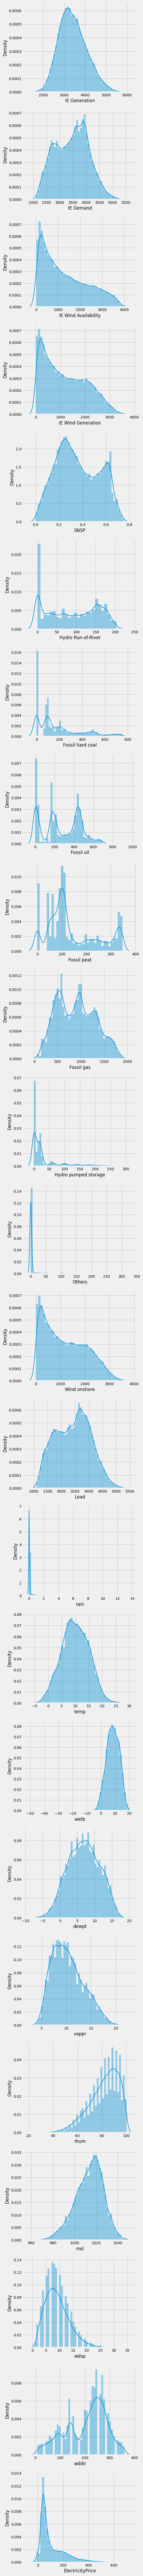

In [32]:
plt.close()
density_plot(final_df.loc[:,final_df.columns[1]:],[])
plt.show()


In [33]:
final_df.head(3)

TimeStamp  IE Generation  IE Demand  IE Wind Availability  \
0 2019-01-01 00:00:00        2444.54    3005.92                599.98   
1 2019-01-01 01:00:00        2326.80    2865.43                628.30   
2 2019-01-01 02:00:00        1993.39    2613.60                517.65   

   IE Wind Generation    SNSP  Hydro Run-of-River  Fossil hard coal  \
0              599.15  0.4215               128.9               0.0   
1              626.40  0.4324               128.4               0.0   
2              513.24  0.4485               123.4               0.0   

   Fossil oil  Fossil peat  ...  rain  temp  wetb  dewpt  vappr  rhum     msl  \
0        35.3        170.1  ...   0.0   8.8   7.3    5.4    9.0    80  1034.7   
1        28.2        225.0  ...   0.0   8.3   7.0    5.3    9.0    82  1034.7   
2        35.5        224.6  ...   0.0   8.4   7.1    5.4    9.0    82  1034.7   

   wdsp  wddir  ElectricityPrice  
0     9    250             70.28  
1     9    250             65.18  
2     8    240             60.91  

[3 rows x 25 columns]

In [34]:
finaldf2=df_handle_outliers(final_df)

In [35]:
finaldf2.head(3)

TimeStamp  IE Generation  IE Demand  IE Wind Availability  \
0 2019-01-01 00:00:00        2444.54    3005.92                599.98   
1 2019-01-01 01:00:00        2326.80    2865.43                628.30   
2 2019-01-01 02:00:00        1993.39    2613.60                517.65   

   IE Wind Generation    SNSP  Hydro Run-of-River  Fossil hard coal  \
0              599.15  0.4215               128.9               0.0   
1              626.40  0.4324               128.4               0.0   
2              513.24  0.4485               123.4               0.0   

   Fossil oil  Fossil peat  ...  rain  temp  wetb  dewpt  vappr  rhum     msl  \
0        35.3        170.1  ...   0.0   8.8   7.3    5.4    9.0  80.0  1034.7   
1        28.2        225.0  ...   0.0   8.3   7.0    5.3    9.0  82.0  1034.7   
2        35.5        224.6  ...   0.0   8.4   7.1    5.4    9.0  82.0  1034.7   

   wdsp  wddir  ElectricityPrice  
0   9.0  250.0             70.28  
1   9.0  250.0             65.18  
2   8.0  240.0             60.91  

[3 rows x 25 columns]

In [36]:
num_overview2 = numerical_overview(finaldf2.loc[:,finaldf2.columns[1]:], [])
num_overview2.head(num_overview2.shape[0])

C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, 

Variable name +ve value count -ve value count Zero count  \
0          IE Generation           35064               0          0   
1              IE Demand           35064               0          0   
2   IE Wind Availability           35064               0          0   
3     IE Wind Generation           35046               0         18   
4                   SNSP           35064               0          0   
5     Hydro Run-of-River           25795               0       5094   
6       Fossil hard coal           23370               0       7519   
7             Fossil oil           27317               0       3572   
8            Fossil peat           29723               0       1166   
9             Fossil gas           30889               0          0   
10  Hydro pumped storage           19024               0      11865   
11                Others               0               0      30889   
12          Wind onshore           30876               0         13   
13                  Load           28566               0          0   
14                  rain               0               0      35064   
15                  temp           34292             728         44   
16                  wetb           34014            1005         45   
17                 dewpt           32652            2305        107   
18                 vappr           35064               0          0   
19                  rhum           35064               0          0   
20                   msl           35064               0          0   
21                  wdsp           35060               0          4   
22                 wddir           35062               0          2   
23      ElectricityPrice           32638             634        272   

   Unique count +ve infinity count -ve infinity count  missing %  \
0         32266                  0                  0   0.000000   
1         32424                  0                  0   0.000000   
2         32963                  0                  0   0.000000   
3         32738                  0                  0   0.000000   
4          6997                  0                  0   0.000000   
5          2033                  0                  0  11.906799   
6          2983                  0                  0  11.906799   
7          5236                  0                  0  11.906799   
8          2970                  0                  0  11.906799   
9         13166                  0                  0  11.906799   
10          520                  0                  0  11.906799   
11            2                  0                  0  11.906799   
12        18491                  0                  0  11.906799   
13        16639                  0                  0  18.531828   
14            1                  0                  0   0.000000   
15          287                  0                  0   0.000000   
16          250                  0                  0   0.000000   
17          253                  0                  0   0.000000   
18          159                  0                  0   0.000000   
19           53                  0                  0   0.000000   
20          680                  0                  0   0.000000   
21           22                  0                  0   0.000000   
22           37                  0                  0   0.000000   
23        12783                  0                  0   4.334930   

   Count of outliers  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
5                  0  
6                  0  
7                  0  
8                  0  
9                  0  
10                 0  
11                 0  
12                 0  
13                 0  
14                 0  
15                 0  
16                 0  
17                 0  
18                 0  
19                 0  
20                 0  
21                 0  
22   

#### Density plot without outliers

C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:162: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plot_df[col], ax=a)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:162: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plot_df[col], ax=a)
C:\Users\kagau\AppData\Local

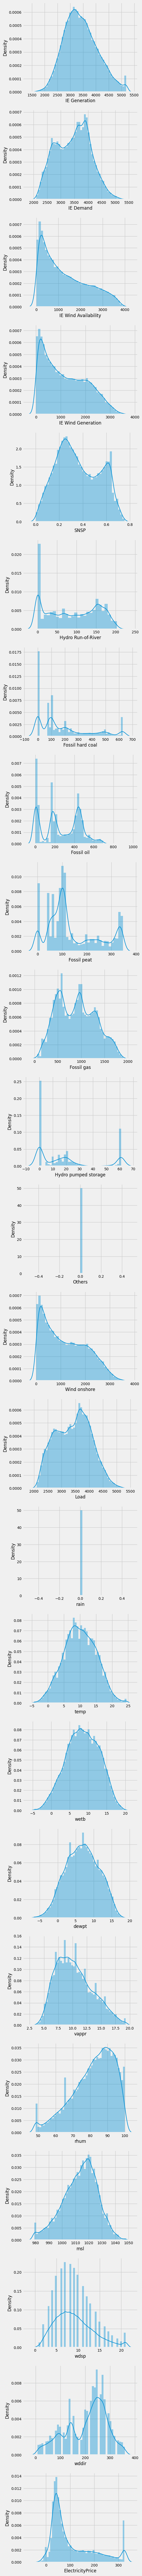

In [37]:
plt.close()
density_plot(finaldf2.loc[:,finaldf2.columns[1]:],[], False)
plt.show()

#### Box plot with Outliers

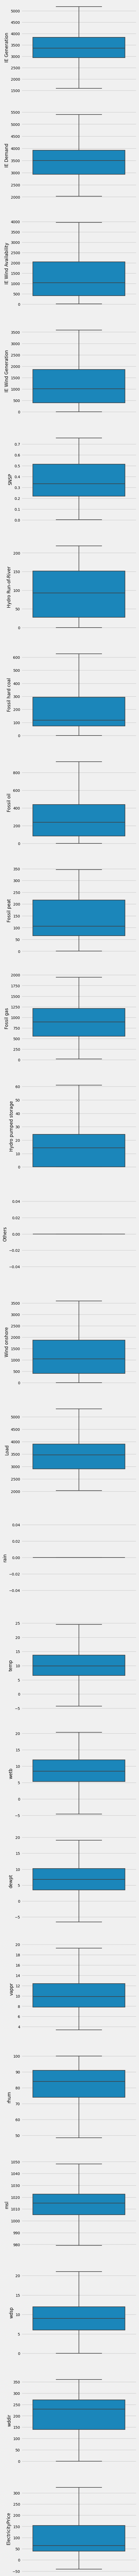

In [38]:
plt.close()
box_plot(final_df.loc[:,final_df.columns[1]:], [])
plt.show()

#### Box plot without outliers

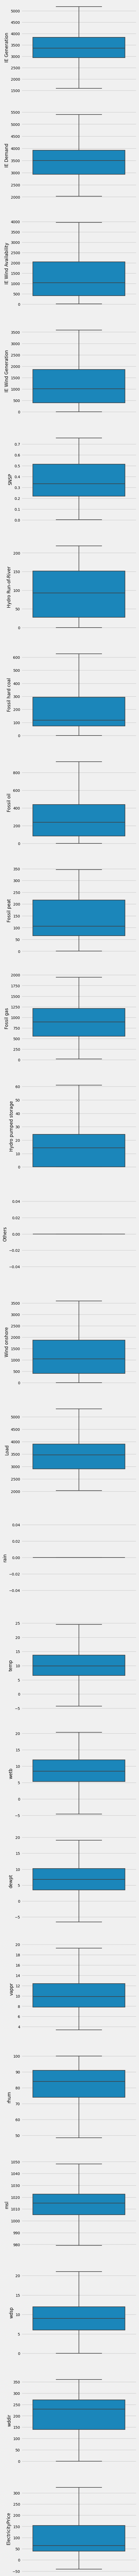

In [39]:
plt.close()
box_plot(finaldf2.loc[:,finaldf2.columns[1]:], [],False)
plt.show()

### Correlation matrix

In [40]:
df = final_df.loc[:,final_df.columns[1]:]._get_numeric_data()
df.corr()

IE Generation  IE Demand  IE Wind Availability  \
IE Generation              1.000000   0.810901              0.483655   
IE Demand                  0.810901   1.000000              0.133793   
IE Wind Availability       0.483655   0.133793              1.000000   
IE Wind Generation         0.546931   0.195830              0.979126   
SNSP                       0.247061   0.028399              0.912439   
Hydro Run-of-River         0.473941   0.456383              0.265270   
Fossil hard coal           0.175393   0.313974             -0.219216   
Fossil oil                -0.016267   0.191847             -0.516499   
Fossil peat                0.134193   0.168608             -0.058388   
Fossil gas                 0.145243   0.276675             -0.522840   
Hydro pumped storage       0.397667   0.515086             -0.014109   
Others                          NaN        NaN                   NaN   
Wind onshore               0.574531   0.208013              0.974392   
Load                       0.791602   0.983596              0.137391   
rain                            NaN        NaN                   NaN   
temp                      -0.106356  -0.041671             -0.076630   
wetb                      -0.140497  -0.099554             -0.096232   
dewpt                     -0.176856  -0.164481             -0.124947   
vappr                     -0.170618  -0.154457             -0.136761   
rhum                      -0.141803  -0.246105             -0.110667   
msl                       -0.181565  -0.063147             -0.410819   
wdsp                       0.354390   0.197098              0.659541   
wddir                      0.004992   0.003516              0.013282   
ElectricityPrice           0.245168   0.343970             -0.134802   

                      IE Wind Generation      SNSP  Hydro Run-of-River  \
IE Generation                   0.546931  0.247061            0.473941   
IE Demand                       0.195830  0.028399            0.456383   
IE Wind Availability            0.979126  0.912439            0.265270   
IE Wind Generation              1.000000  0.905528            0.289403   
SNSP                            0.905528  1.000000            0.222406   
Hydro Run-of-River              0.289403  0.222406            1.000000   
Fossil hard coal               -0.203093 -0.287996           -0.033701   
Fossil oil                     -0.508006 -0.551975            0.035722   
Fossil peat                    -0.026104 -0.036517            0.359239   
Fossil gas                     -0.496155 -0.622832           -0.009696   
Hydro pumped storage            0.015898 -0.078248            0.195710   
Others                               NaN       NaN                 NaN   
Wind onshore                    0.995898  0.899658            0.289814   
Load                            0.202249  0.038682            0.477090   
rain                                 NaN       NaN                 NaN   
temp                           -0.093256 -0.058084           -0.362928   
wetb                           -0.113822 -0.086894           -0.371229   
dewpt                          -0.142580 -0.126879           -0.356365   
vappr                          -0.153069 -0.141771           -0.357285   
rhum                           -0.109858 -0.151254            0.039081   
msl                            -0.399879 -0.379116           -0.204492   
wdsp                            0.645281  0.631821            0.205049   
wddir                           0.012797  0.022748            0.083363   
ElectricityPrice               -0.104801 -0.210317           -0.024625   

                      Fossil hard coal  Fossil oil  Fossil peat  Fossil gas  \
IE Generation                 0.175393   -0.016267     0.134193    0.145243   
IE Demand                     0.313974    0.191847     0.168608    0.276675   
IE Wind Availability         -0.219216   -0.516499    -0.058388   -0.522840   
IE Wind Generation           -0.203093   -0.508006    

In [41]:
df = finaldf2.loc[:,finaldf2.columns[1]:]._get_numeric_data()
df.corr(method='spearman')

IE Generation  IE Demand  IE Wind Availability  \
IE Generation              1.000000   0.799669              0.487256   
IE Demand                  0.799669   1.000000              0.123145   
IE Wind Availability       0.487256   0.123145              1.000000   
IE Wind Generation         0.526406   0.164715              0.992720   
SNSP                       0.256777   0.032325              0.911085   
Hydro Run-of-River         0.477684   0.455926              0.272274   
Fossil hard coal           0.147168   0.289754             -0.188049   
Fossil oil                -0.062119   0.174877             -0.547476   
Fossil peat                0.157689   0.191258             -0.038776   
Fossil gas                 0.133729   0.268789             -0.515537   
Hydro pumped storage       0.450336   0.583135              0.009076   
Others                          NaN        NaN                   NaN   
Wind onshore               0.554934   0.176673              0.988015   
Load                       0.776459   0.982739              0.123958   
rain                            NaN        NaN                   NaN   
temp                      -0.095465  -0.044641             -0.094594   
wetb                      -0.131828  -0.098131             -0.117242   
dewpt                     -0.167785  -0.158265             -0.134687   
vappr                     -0.167850  -0.158335             -0.134769   
rhum                      -0.194906  -0.272503             -0.145805   
msl                       -0.188204  -0.062332             -0.411051   
wdsp                       0.360829   0.200597              0.636703   
wddir                     -0.027183  -0.005534             -0.056162   
ElectricityPrice           0.225178   0.392547             -0.163813   

                      IE Wind Generation      SNSP  Hydro Run-of-River  \
IE Generation                   0.526406  0.256777            0.477684   
IE Demand                       0.164715  0.032325            0.455926   
IE Wind Availability            0.992720  0.911085            0.272274   
IE Wind Generation              1.000000  0.903489            0.288291   
SNSP                            0.903489  1.000000            0.228298   
Hydro Run-of-River              0.288291  0.228298            1.000000   
Fossil hard coal               -0.175649 -0.249176           -0.040912   
Fossil oil                     -0.537353 -0.564876            0.014803   
Fossil peat                    -0.021569 -0.038104            0.345178   
Fossil gas                     -0.495257 -0.623650           -0.010273   
Hydro pumped storage            0.034423 -0.046529            0.239506   
Others                               NaN       NaN                 NaN   
Wind onshore                    0.995826  0.899964            0.289058   
Load                            0.168748  0.041134            0.475606   
rain                                 NaN       NaN                 NaN   
temp                           -0.104263 -0.069145           -0.375922   
wetb                           -0.127665 -0.101714           -0.384385   
dewpt                          -0.145512 -0.132031           -0.365139   
vappr                          -0.145594 -0.132081           -0.365125   
rhum                           -0.146725 -0.190713            0.000142   
msl                            -0.404388 -0.383719           -0.199487   
wdsp                            0.630055  0.621878            0.208077   
wddir                          -0.056256 -0.049404            0.049250   
ElectricityPrice               -0.137675 -0.216344           -0.018806   

                      Fossil hard coal  Fossil oil  Fossil peat  Fossil gas  \
IE Generation                 0.147168   -0.062119     0.157689    0.133729   
IE Demand                     0.289754    0.174877     0.191258    0.268789   
IE Wind Availability         -0.188049   -0.547476    -0.038776   -0.515537   
IE Wind Generation           -0.175649   -0.537353    

Removing the columns that are highly correlated and has single values in the dataset.

In [42]:
final_df2=finaldf2.drop(columns=['Others', 'Wind onshore','Load','rain','Hydro pumped storage','wetb','dewpt','vappr','msl','wddir','wdsp','IE Wind Availability'])
final_df2.shape

(35064, 13)

In [43]:
final_df2.head(3)

TimeStamp  IE Generation  IE Demand  IE Wind Generation    SNSP  \
0 2019-01-01 00:00:00        2444.54    3005.92              599.15  0.4215   
1 2019-01-01 01:00:00        2326.80    2865.43              626.40  0.4324   
2 2019-01-01 02:00:00        1993.39    2613.60              513.24  0.4485   

   Hydro Run-of-River  Fossil hard coal  Fossil oil  Fossil peat  Fossil gas  \
0               128.9               0.0        35.3        170.1       979.2   
1               128.4               0.0        28.2        225.0       808.3   
2               123.4               0.0        35.5        224.6       616.3   

   temp  rhum  ElectricityPrice  
0   8.8  80.0             70.28  
1   8.3  82.0             65.18  
2   8.4  82.0             60.91

In [44]:
final_df2['TimeStamp'] = pd.to_datetime(final_df2['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')


In [45]:
final_df2=final_df2.drop(final_df2[final_df2['TimeStamp']>pd.to_datetime('29-06-2022  23:00:00')].index)
final_df2.shape

(30623, 13)

In [46]:
final_df2=final_df2.drop_duplicates(subset=['TimeStamp'])
final_df2.shape

(30620, 13)

Creating a single merged file for easy operation.

In [47]:
num_overview2 = numerical_overview(final_df2.loc[:,final_df2.columns[0]:], [])
num_overview2.head(num_overview2.shape[0])

C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15228\563479837.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, 

Variable name +ve value count -ve value count Zero count  \
0        IE Generation           30620               0          0   
1            IE Demand           30620               0          0   
2   IE Wind Generation           30602               0         18   
3                 SNSP           30620               0          0   
4   Hydro Run-of-River           25064               0       5094   
5     Fossil hard coal           22645               0       7513   
6           Fossil oil           26801               0       3357   
7          Fossil peat           28992               0       1166   
8           Fossil gas           30158               0          0   
9                 temp           29985             597         38   
10                rhum           30620               0          0   
11    ElectricityPrice           29087             616        242   

   Unique count +ve infinity count -ve infinity count  missing %  \
0         28507                  0                  0   0.000000   
1         28665                  0                  0   0.000000   
2         28849                  0                  0   0.000000   
3          6776                  0                  0   0.000000   
4          2033                  0                  0   1.508818   
5          2976                  0                  0   1.508818   
6          5229                  0                  0   1.508818   
7          2962                  0                  0   1.508818   
8         13054                  0                  0   1.508818   
9           286                  0                  0   0.000000   
10           53                  0                  0   0.000000   
11        11649                  0                  0   2.204442   

   Count of outliers  
0                190  
1                  0  
2                  0  
3                  0  
4                  0  
5                  0  
6                  0  
7                  0  
8                  0  
9                 63  
10                 0  
11              2062

In [48]:
final_df2=df_handle_outliers(final_df2)

In [49]:
df=final_df2.copy()

In [50]:
df['Hydro Run-of-River']= df['Hydro Run-of-River'].interpolate(method='linear')
df['Fossil hard coal']= df['Fossil hard coal'].interpolate(method='linear')
df['Fossil oil']= df['Fossil oil'].interpolate(method='linear')
df['Fossil peat']= df['Fossil peat'].interpolate(method='linear')
df['Fossil gas']= df['Fossil gas'].interpolate(method='linear')
df['ElectricityPrice']= df['ElectricityPrice'].interpolate(method='linear')

In [51]:


df['day'] = df['TimeStamp'].dt.day
df['month'] = df['TimeStamp'].dt.month
df['hour'] = df['TimeStamp'].dt.hour
#df['dayofyear'] = df['TimeStamp'].dt.dayofyear
#df['week'] = df['TimeStamp'].dt.week
df['dayofweek'] = df['TimeStamp'].dt.dayofweek
#df['quarter'] = df['TimeStamp'].dt.quarter
df.head()

TimeStamp  IE Generation  IE Demand  IE Wind Generation    SNSP  \
0 2019-01-01 00:00:00        2444.54    3005.92              599.15  0.4215   
1 2019-01-01 01:00:00        2326.80    2865.43              626.40  0.4324   
2 2019-01-01 02:00:00        1993.39    2613.60              513.24  0.4485   
3 2019-01-01 03:00:00        1752.69    2470.13              489.53  0.4832   
4 2019-01-01 04:00:00        1717.17    2384.35              378.44  0.4460   

   Hydro Run-of-River  Fossil hard coal  Fossil oil  Fossil peat  Fossil gas  \
0               128.9               0.0        35.3        170.1       979.2   
1               128.4               0.0        28.2        225.0       808.3   
2               123.4               0.0        35.5        224.6       616.3   
3               124.1               0.0        35.6        190.7       451.6   
4               124.4               0.0        36.0        197.1       458.5   

   temp  rhum  ElectricityPrice  day  month  hour  dayofweek  
0   8.8  80.0             70.28    1      1     0          1  
1   8.3  82.0             65.18    1      1     1          1  
2   8.4  82.0             60.91    1      1     2          1  
3   8.6  82.0             65.16    1      1     3          1  
4   8.4  85.0             65.16    1      1     4          1

In [52]:
df.drop_duplicates(subset=['TimeStamp'])

TimeStamp  IE Generation  IE Demand  IE Wind Generation  \
0     2019-01-01 00:00:00        2444.54    3005.92              599.15   
1     2019-01-01 01:00:00        2326.80    2865.43              626.40   
2     2019-01-01 02:00:00        1993.39    2613.60              513.24   
3     2019-01-01 03:00:00        1752.69    2470.13              489.53   
4     2019-01-01 04:00:00        1717.17    2384.35              378.44   
...                   ...            ...        ...                 ...   
30618 2022-06-29 19:00:00        3978.34    3879.64              367.16   
30619 2022-06-29 20:00:00        3843.57    3725.62              311.32   
30620 2022-06-29 21:00:00        3796.31    3601.76              290.98   
30621 2022-06-29 22:00:00        3754.00    3467.82              309.83   
30622 2022-06-29 23:00:00        3536.75    3262.64              268.24   

         SNSP  Hydro Run-of-River  Fossil hard coal  Fossil oil  Fossil peat  \
0      0.4215               128.9               0.0        35.3        170.1   
1      0.4324               128.4               0.0        28.2        225.0   
2      0.4485               123.4               0.0        35.5        224.6   
3      0.4832               124.1               0.0        35.6        190.7   
4      0.4460               124.4               0.0        36.0        197.1   
...       ...                 ...               ...         ...          ...   
30618  0.0931               116.3             456.0       146.4         96.5   
30619  0.0751                92.3             450.7       123.8         93.6   
30620  0.0668                80.5             450.7       122.2         93.6   
30621  0.0732                59.7             340.1       121.5         96.1   
30622  0.0682                33.1             335.2        36.0         96.2   

       Fossil gas  temp  rhum  ElectricityPrice  day  month  hour  dayofweek  
0           979.2   8.8  80.0            70.280    1      1     0          1  
1           808.3   8.3  82.0            65.180    1      1     1          1  
2           616.3   8.4  82.0            60.910    1      1     2          1  
3           451.6   8.6  82.0            65.160    1      1     3          1  
4           458.5   8.4  85.0            65.160    1      1     4          1  
...           ...   ...   ...               ...  ...    ...   ...        ...  
30618      1658.4  15.8  73.0           245.195   29      6    19          2  
30619      1678.3  14.5  80.0           245.195   29      6    20          2  
30620      1649.8  14.0  77.0           228.590   29      6    21          2  
30621      1630.2  13.3  82.0           228.590   29      6    22          2  
30622      1642.1  12.9  87.0           228.590   29      6    23          2  

[30620 rows x 17 columns]

# Data exploration

Analysing trends for energy demand and electricity price across the months.

Text(0, 0.5, 'ElectricityPrice in Euro')

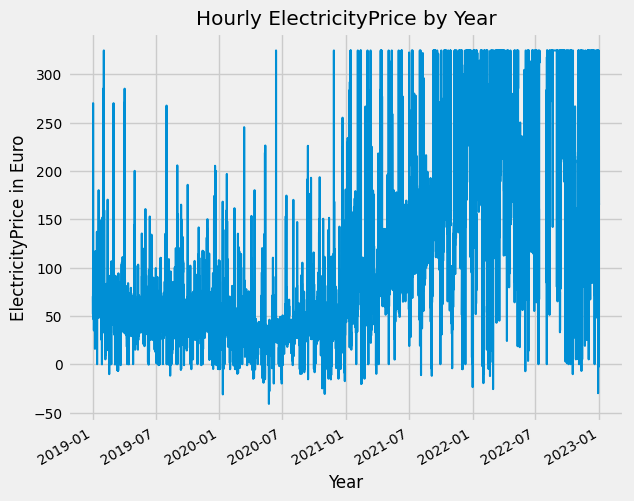

In [53]:
plt.plot(final_df.TimeStamp, final_df.ElectricityPrice)
plt.title('Hourly ElectricityPrice by Year')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Year')
plt.ylabel('ElectricityPrice in Euro')

Text(0, 0.5, 'Demand in MWh')

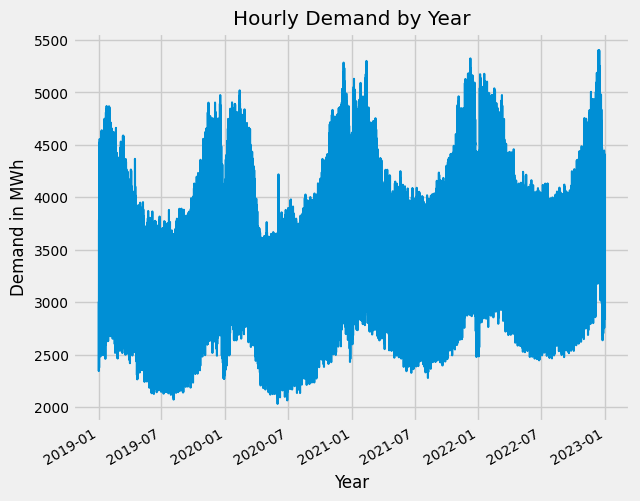

In [54]:
plt.plot(final_df.TimeStamp, final_df['IE Demand'])
plt.title('Hourly Demand by Year')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Year')
plt.ylabel('Demand in MWh')

In [55]:
monthlymeanDemand= final_df.groupby(pd.Grouper(key='TimeStamp', freq='M'))['IE Demand'].mean()
monthlymeanDemand.head()

TimeStamp
2019-01-31    3572.675645
2019-02-28    3561.799449
2019-03-31    3471.246972
2019-04-30    3343.061278
2019-05-31    3157.463710
Freq: M, Name: IE Demand, dtype: float64

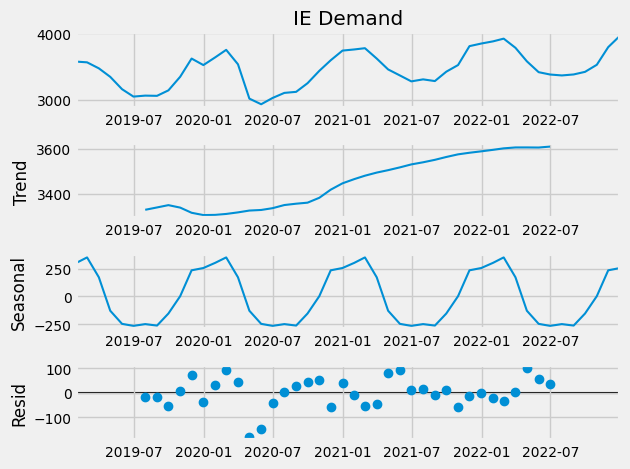

In [56]:


decompose_result_mult = seasonal_decompose(monthlymeanDemand, model="addictive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

In [57]:
monthlymeanPrice= final_df2.groupby(pd.Grouper(key='TimeStamp', freq='M'))['ElectricityPrice'].mean()
monthlymeanPrice.head()

TimeStamp
2019-01-31    64.726089
2019-02-28    53.085804
2019-03-31    49.393668
2019-04-30    49.257021
2019-05-31    48.396035
Freq: M, Name: ElectricityPrice, dtype: float64

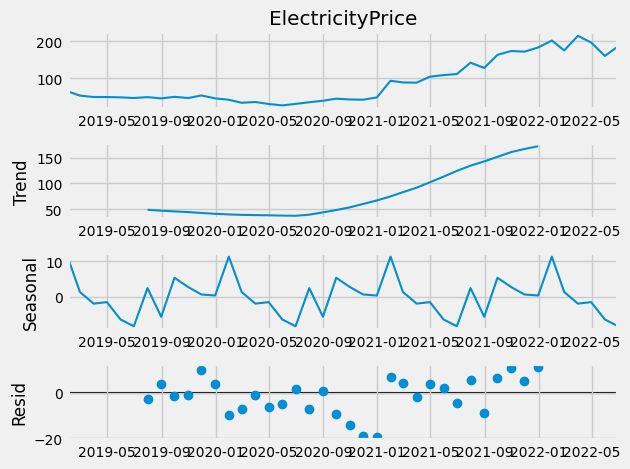

In [58]:


decompose_result_mult = seasonal_decompose(monthlymeanPrice, model="addictive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

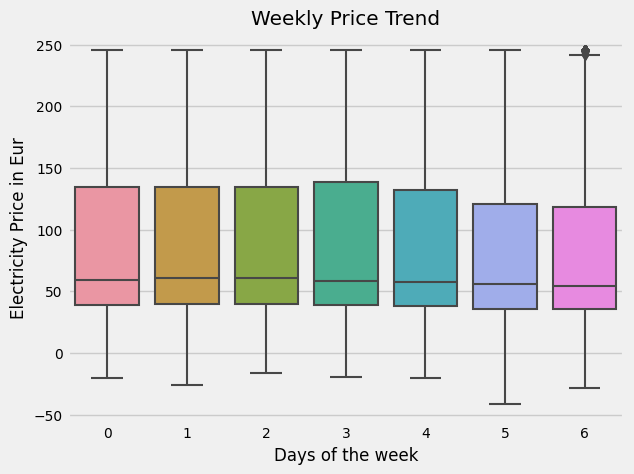

In [59]:
sns.boxplot(x=df['dayofweek'], y=df['ElectricityPrice'], )
plt.title('Weekly Price Trend')
plt.xlabel('Days of the week')
plt.ylabel('Electricity Price in Eur')
plt.show()

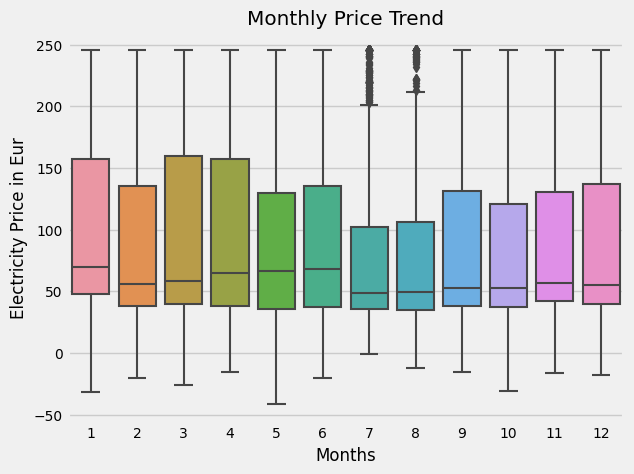

In [60]:
sns.boxplot(x=df['month'], y=df['ElectricityPrice'], )
plt.title('Monthly Price Trend')
plt.xlabel('Months')
plt.ylabel('Electricity Price in Eur')
plt.show()

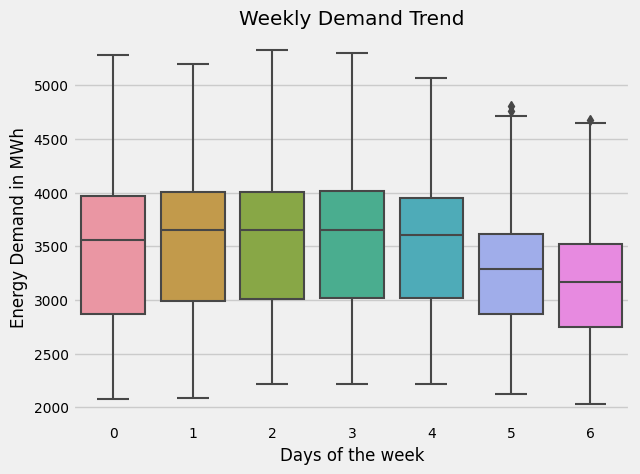

In [61]:
sns.boxplot(x=df['dayofweek'], y=df['IE Demand'], )
plt.title('Weekly Demand Trend')
plt.xlabel('Days of the week')
plt.ylabel('Energy Demand in MWh')
plt.show()


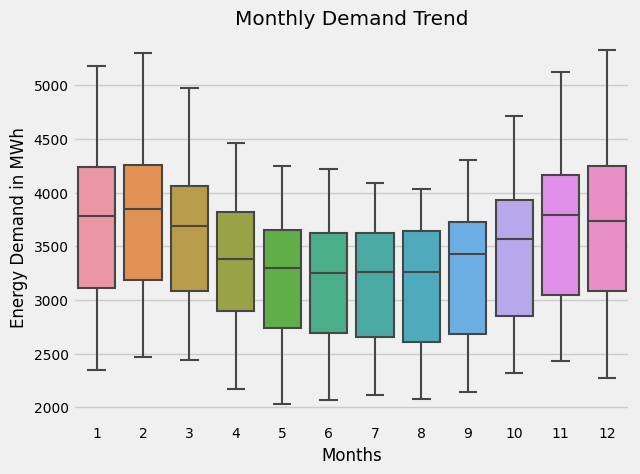

In [62]:
sns.boxplot(x=df['month'], y=df['IE Demand'], )
plt.title('Monthly Demand Trend')
plt.xlabel('Months')
plt.ylabel('Energy Demand in MWh')
plt.show()

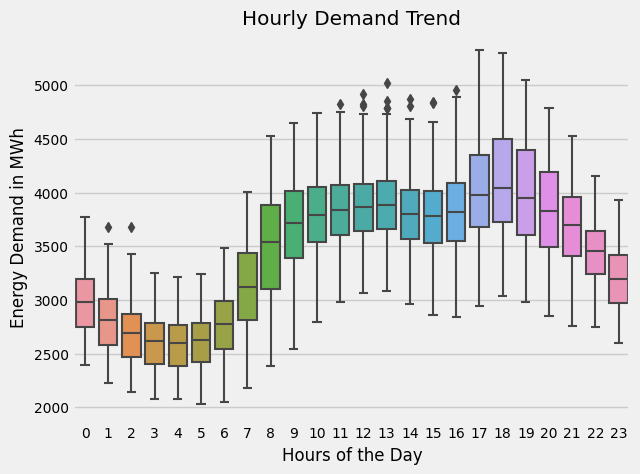

In [63]:
sns.boxplot(x=df['hour'], y=df['IE Demand'], )
plt.title('Hourly Demand Trend')
plt.xlabel('Hours of the Day')
plt.ylabel('Energy Demand in MWh')
plt.show()

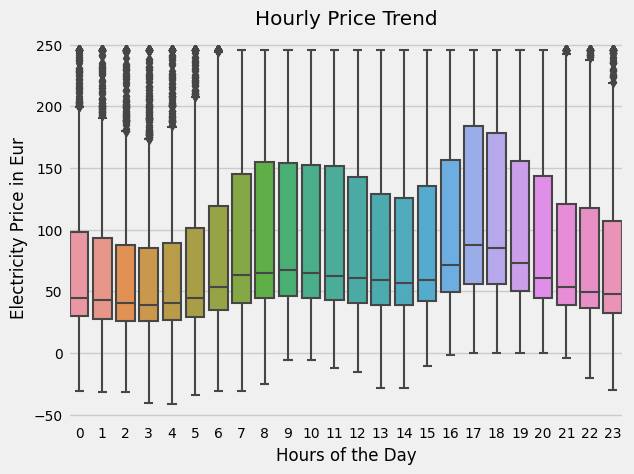

In [64]:
sns.boxplot(x=df['hour'], y=df['ElectricityPrice'], )
plt.title('Hourly Price Trend')
plt.xlabel('Hours of the Day')
plt.ylabel('Electricity Price in Eur')
plt.show()

Text(0.5, 1.0, 'Autocorrelation of Energy Demand')

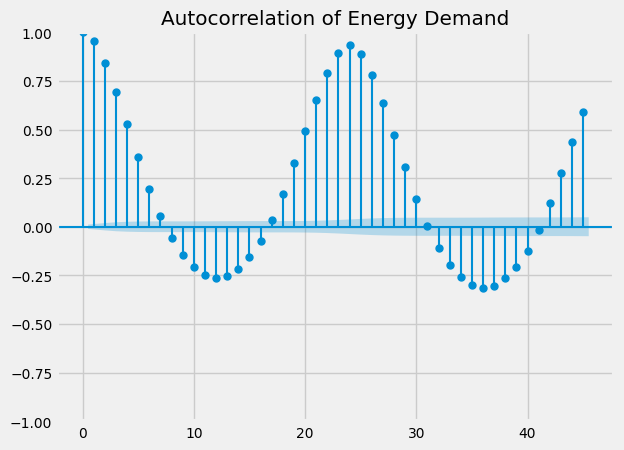

In [65]:
plot_acf(df['IE Demand'])
plt.title('Autocorrelation of Energy Demand')

Text(0.5, 1.0, 'Autocorrelation of Electricity Price')

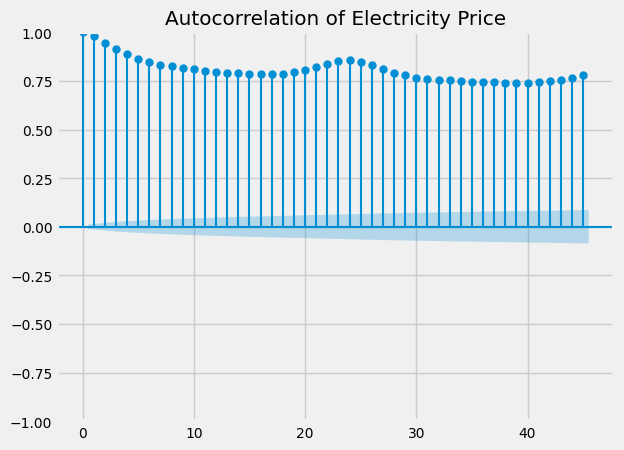

In [66]:
plot_acf(df['ElectricityPrice'])
plt.title('Autocorrelation of Electricity Price')

c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'Partial-Autocorrelation of Energy Demand')

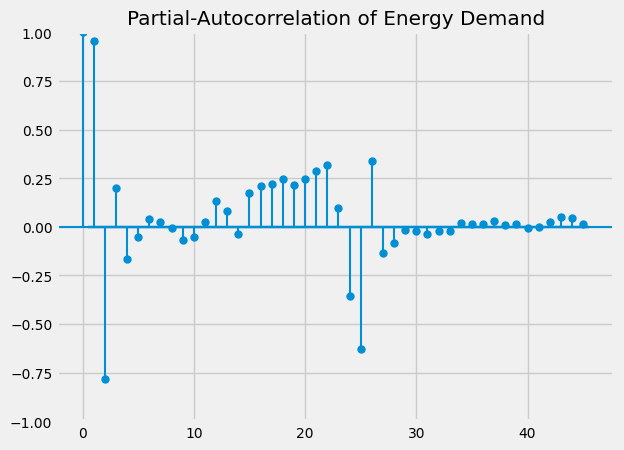

In [67]:
plot_pacf(df['IE Demand'])
plt.title('Partial-Autocorrelation of Energy Demand')

Text(0.5, 1.0, 'Partial-Autocorrelation of Electricity Price')

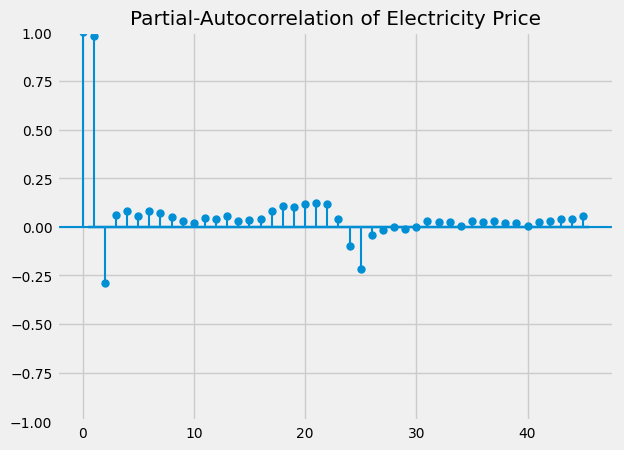

In [68]:
plot_pacf(df['ElectricityPrice'])
plt.title('Partial-Autocorrelation of Electricity Price')

In [69]:
result = adfuller(df['ElectricityPrice'])

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

ADF Statistic: -5.866965
p-value: 0.000000


In [70]:
result = adfuller(df['IE Demand'])

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

ADF Statistic: -10.696416
p-value: 0.000000


## Preparing final cleaned dataset for model training and testing.

In [71]:
data=df.copy()
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('TimeStamp')
data = data.asfreq('H')
data = data.sort_index()
data.head(2)

IE Generation  IE Demand  IE Wind Generation    SNSP  \
TimeStamp                                                                   
2019-01-01 00:00:00        2444.54    3005.92              599.15  0.4215   
2019-01-01 01:00:00        2326.80    2865.43              626.40  0.4324   

                     Hydro Run-of-River  Fossil hard coal  Fossil oil  \
TimeStamp                                                               
2019-01-01 00:00:00               128.9               0.0        35.3   
2019-01-01 01:00:00               128.4               0.0        28.2   

                     Fossil peat  Fossil gas  temp  rhum  ElectricityPrice  \
TimeStamp                                                                    
2019-01-01 00:00:00        170.1       979.2   8.8  80.0             70.28   
2019-01-01 01:00:00        225.0       808.3   8.3  82.0             65.18   

                     day  month  hour  dayofweek  
TimeStamp                                         
2019-01-01 00:00:00  1.0    1.0   0.0        1.0  
2019-01-01 01:00:00  1.0    1.0   1.0        1.0

In [72]:
data=data.fillna(method='ffill')
data['ElectricityPrice'] = data['ElectricityPrice'].fillna(0)
data['IE Demand'] = data['IE Demand'].fillna(0)

In [73]:
data=data.drop(data[data.index>pd.to_datetime('31-12-2021  23:00:00')].index)
data.shape

(26304, 16)

In [74]:
min_date = data.index.min()
max_date = data.index.max()
print("Min:", min_date, "Max:", max_date)
train_percent = .80
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_cutoff

Min: 2019-01-01 00:00:00 Max: 2021-12-31 23:00:00


Timestamp('2021-05-26 18:24:00', freq='H')

In [77]:
train_df = data[data.index <= train_cutoff]
test_df = data[data.index > train_cutoff]

print("Train:", train_df.index.min(), train_df.index.max(), len(train_df))
print("Test:", test_df.index.min(), test_df.index.max(), len(test_df))

Train: 2019-01-01 00:00:00 2021-05-26 18:00:00 21043
Test: 2021-05-26 19:00:00 2021-12-31 23:00:00 5261


In [76]:
train_df=train_df.drop(columns=['ElectricityPrice'])
test_df=test_df.drop(columns=['ElectricityPrice'])

In [79]:
exogenous_features = list(data)
exogenous_features.remove('ElectricityPrice')
exogenous_features.remove('IE Demand')
exogenous_features

['IE Generation',
 'IE Wind Generation',
 'SNSP',
 'Hydro Run-of-River',
 'Fossil hard coal',
 'Fossil oil',
 'Fossil peat',
 'Fossil gas',
 'temp',
 'rhum',
 'day',
 'month',
 'hour',
 'dayofweek']

# Modelling for Energy Demand Forecast

## Model 1: SARIMAX

In [93]:
mod = sm.tsa.statespace.SARIMAX(
                train_df['IE Demand'],
                exog=train_df.loc[:, exogenous_features],
                order=(1, 1, 1),
                seasonal_order=(0, 0, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = mod.fit()

c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [94]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         IE Demand   No. Observations:                21043
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 7)   Log Likelihood             -125062.300
Date:                           Tue, 01 Aug 2023   AIC                         250160.600
Time:                                   19:24:46   BIC                         250303.769
Sample:                               01-01-2019   HQIC                        250207.326
                                    - 05-26-2021                                         
Covariance Type:                             opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
IE Generation          0.8357      0.005    169.188      0.000       0.826       0.845
IE Wind Generation    -0.7338      0.008    -87.611      0.000      -0.750      -0.717
SNSP                3236.8763     29.436    109.962      0.000    3179.182    3294.570
Hydro Run-of-River     0.7919      0.052     15.144      0.000       0.689       0.894
Fossil hard coal       0.1746      0.025      6.970      0.000       0.126       0.224
Fossil oil             0.1023      0.010      9.942      0.000       0.082       0.122
Fossil peat            0.4780      0.031     15.301      0.000       0.417       0.539
Fossil gas             0.0780      0.006     13.816      0.000       0.067       0.089
temp                   9.9309      0.952     10.437      0.000       8.066      11.796
rhum                   0.5824      0.163      3.578      0.000       0.263       0.901
day                   -0.0584      0.453     -0.129      0.897      -0.946       0.829
month                -18.1123      3.807     -4.757      0.000     -25.574     -10.650
hour                   0.9235      0.102      9.020      0.000       0.723       1.124
dayofweek             -3.1780      0.938     -3.389      0.001      -5.016      -1.340
ar.L1                  0.3465      0.015     22.514      0.000       0.316       0.377
ma.L1                  0.0918      0.015      5.994      0.000       0.062       0.122
ma.S.L7               -0.1583      0.007    -22.764      0.000      -0.172      -0.145
sigma2              8660.0140     54.785    158.072      0.000    8552.637    8767.391
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             13189.44
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

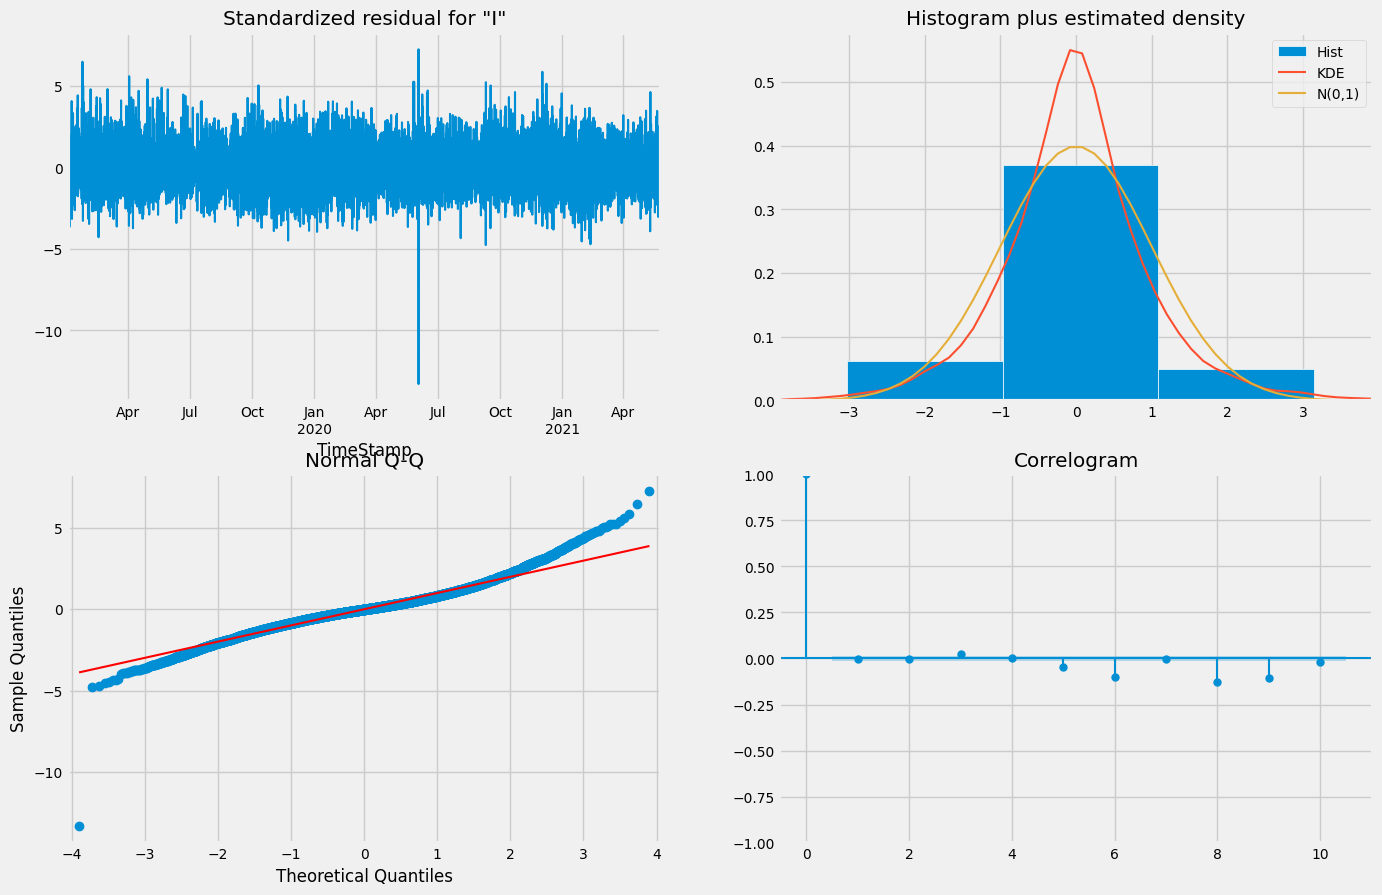

In [95]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

In [96]:
steps = len(test_df)
pred = results.get_forecast(steps=steps, exog=test_df.loc[:, test_df.columns != 'IE Demand'])

In [97]:
y_test=test_df['IE Demand']
y_pred=pred.predicted_mean

In [98]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 286.20946937593556
MSE: 81915.8603604546
MAE: 221.7187866705165
MAPE: 0.06974893765328223
Max Error: 1160.5951565099367
Explained Variance Score: 0.8029689620426214
R2Score: 0.7873360403774686


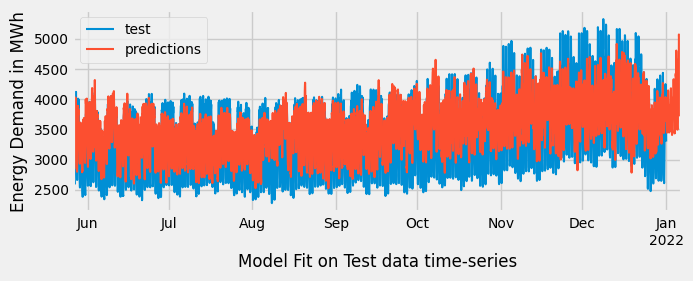

In [147]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
plt.xlabel('Model Fit on Test data time-series')
plt.ylabel('Energy Demand in MWh')
ax.legend();

In [117]:
pred_data=df.copy()
pred_data['TimeStamp'] = pd.to_datetime(pred_data['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')

In [118]:
pred_data=pred_data.drop(pred_data[pred_data['TimeStamp']>pd.to_datetime('01-07-2022  00:00:00')].index)
pred_data.shape

(26446, 17)

In [119]:
pred_data=pred_data.drop(pred_data[pred_data['TimeStamp']<=pd.to_datetime('26-05-2021  19:00:00')].index)
pred_data.shape

(5405, 17)

In [120]:
pred_data=pred_data.drop(columns=['ElectricityPrice'])

In [121]:
pred_data = pred_data.set_index('TimeStamp')
pred_data = pred_data.asfreq('H')
pred_data = pred_data.sort_index()

In [122]:
exog = pred_data.loc[:, pred_data.columns != 'IE Demand']

In [124]:
y_pred = results.forecast(steps=5405, exog=exog)

In [126]:
ypred_sarimax=y_pred.drop(y_pred[y_pred.index<=pd.to_datetime('31-12-2021  23:00:00')].index)

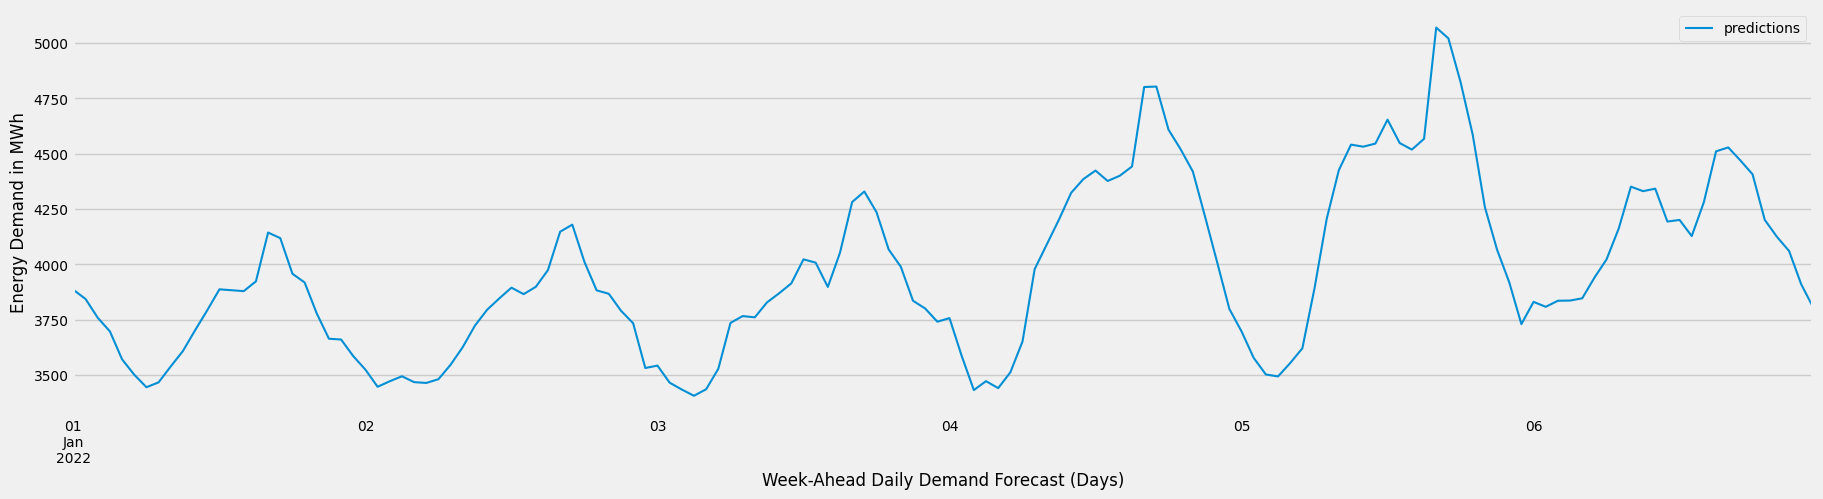

In [188]:
fig, ax = plt.subplots(figsize=(20, 5))

ypred_sarimax.plot(ax=ax, label='predictions')
plt.xlabel('Week-Ahead Daily Demand Forecast (Days)')
plt.ylabel('Energy Demand in MWh')
ax.legend();
plt.show()

In [237]:
Demand_result = pd.DataFrame(ypred_sarimax)

Demand_result=Demand_result.rename(columns={'predicted_mean': 'Sarimax'})

Demand_result.head(2)

Sarimax
2022-01-01 00:00:00  3885.592683
2022-01-01 01:00:00  3843.949674

## Model 2: Prophet

In [130]:
model =  Prophet(changepoint_prior_scale = 0.001, seasonality_prior_scale= 10.0)

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path


In [131]:
for feature in exogenous_features:
	model.add_regressor(feature)

In [134]:
train_df_prophet = train_df.reset_index()
train_df_prophet.head(2)
test_df_prophet = test_df.reset_index()

In [135]:
model.fit(train_df_prophet[["TimeStamp", "IE Demand"] + exogenous_features].rename(columns={"TimeStamp": "ds", "IE Demand": "y"}))

cmdstanpy  DEBUG input tempfile: C:\Users\kagau\AppData\Local\Temp\tmpbu9s4_s1\17u56cld.json
cmdstanpy  DEBUG input tempfile: C:\Users\kagau\AppData\Local\Temp\tmpbu9s4_s1\_4gv6e4b.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\kagau\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=25434', 'data', 'file=C:\\Users\\kagau\\AppData\\Local\\Temp\\tmpbu9s4_s1\\17u56cld.json', 'init=C:\\Users\\kagau\\AppData\\Local\\Temp\\tmpbu9s4_s1\\_4gv6e4b.json', 'output', 'file=C:\\Users\\kagau\\AppData\\Local\\Temp\\tmpbu9s4_s1\\prophet_modelr7cfkm2i\\prophet_model-20230801194740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:40 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain [1] start processing
19:47:46 - cmdstanpy - INFO - Chain [1] done processing
cmdstanpy  INFO  Chain [1] done processing


In [136]:
forecast = model.predict(test_df_prophet[["TimeStamp"] + exogenous_features].rename(columns={"TimeStamp": "ds"}))

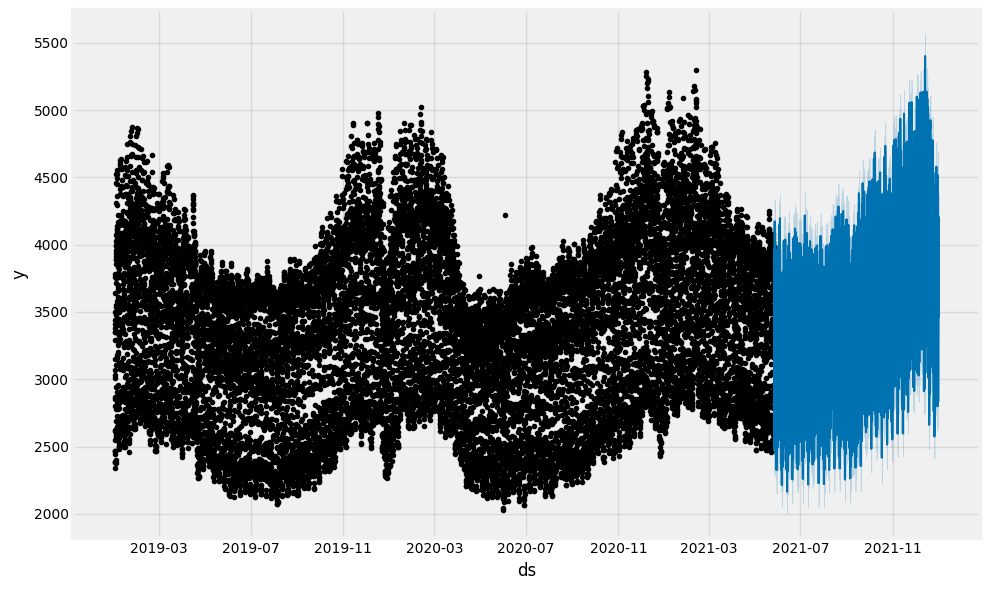

In [137]:
fig = model.plot(forecast)

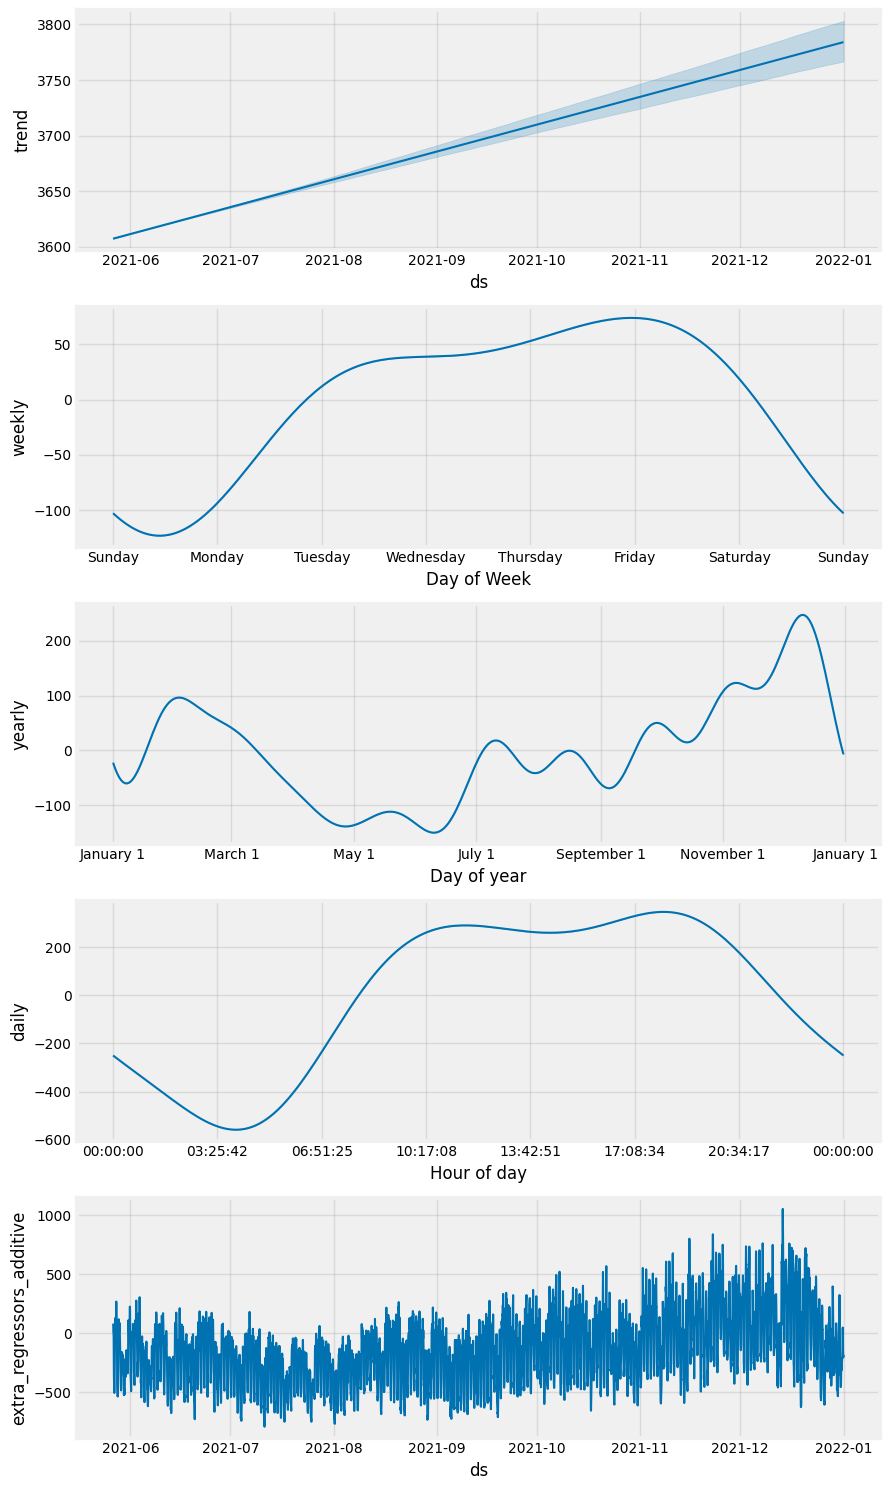

In [138]:
fig2 = model.plot_components(forecast)

In [139]:
result2 = forecast.copy()

In [140]:
result2.head(2)

ds        trend   yhat_lower   yhat_upper  trend_lower  \
0 2021-05-26 19:00:00  3607.409673  3774.687133  4116.430052  3607.409673   
1 2021-05-26 20:00:00  3607.443272  3681.428816  4019.051841  3607.443272   

   trend_upper  Fossil gas  Fossil gas_lower  Fossil gas_upper  \
0  3607.409673   19.103725         19.103725         19.103725   
1  3607.443272   20.667754         20.667754         20.667754   

   Fossil hard coal  ...     weekly  weekly_lower  weekly_upper      yearly  \
0          -29.6665  ...  47.627038     47.627038     47.627038 -120.997849   
1          -29.6665  ...  48.629173     48.629173     48.629173 -121.090072   

   yearly_lower  yearly_upper  multiplicative_terms  \
0   -120.997849   -120.997849                   0.0   
1   -121.090072   -121.090072                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                         0.0                         0.0  3941.043679  
1                         0.0                         0.0  3855.003834  

[2 rows x 67 columns]

In [141]:
result2['TimeStamp'] = pd.to_datetime(result2['ds'], format='%Y-%m-%dT%H:%M:%SZ')
result2 = result2.set_index('TimeStamp')
result2 = result2.asfreq('H')
result2 = result2.sort_index()

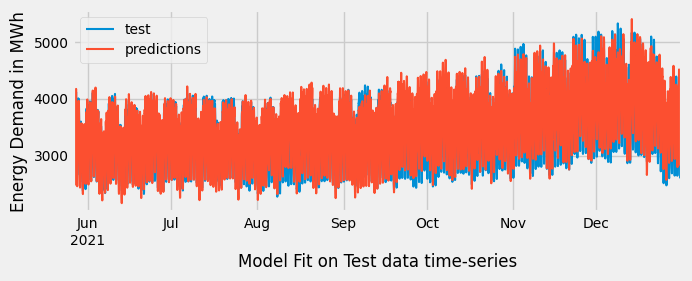

In [146]:
fig, ax = plt.subplots(figsize=(7, 2.5))

y_test.plot(ax=ax, label='test')
result2['yhat'].plot(ax=ax, label='predictions')
plt.xlabel('Model Fit on Test data time-series')
plt.ylabel('Energy Demand in MWh')
ax.legend();

In [148]:
newypred = result2['yhat']

In [149]:
print('RMSE:',mean_squared_error(y_test, newypred, squared = False))
print('MSE:',mean_squared_error(y_test, newypred))
print('MAE:',mean_absolute_error(y_test, newypred))
print('MAPE:',mean_absolute_percentage_error(y_test, newypred))
print('Max Error:',max_error(y_test, newypred))
print('Explained Variance Score:',explained_variance_score(y_test, newypred))
print('R2Score:',r2_score(y_test, newypred))

RMSE: 174.5951738886273
MSE: 30483.474745200005
MAE: 139.55395982046682
MAPE: 0.04120054056411669
Max Error: 629.2333438886071
Explained Variance Score: 0.9449004302131429
R2Score: 0.9208610345561694


In [150]:
pred_data_prophet = pred_data.reset_index()

In [158]:
pred_data_prophet=pred_data_prophet.drop(pred_data_prophet[pred_data_prophet['TimeStamp']<=pd.to_datetime('31-12-2021  23:00:00')].index)
pred_data_prophet.shape

(145, 16)

In [157]:
pred_data_prophet=pred_data_prophet.drop(pred_data_prophet[pred_data_prophet['TimeStamp']>pd.to_datetime('01-07-2022  00:00:00')].index)
pred_data_prophet.shape

(5405, 16)

In [159]:
forecast2 = model.predict(pred_data_prophet[["TimeStamp"] + exogenous_features].rename(columns={"TimeStamp": "ds"}))

In [160]:
result3 = forecast2.copy()

In [161]:
result3.head(5)

ds        trend   yhat_lower   yhat_upper  trend_lower  \
0 2022-01-01 00:00:00  3784.169173  3238.881834  3588.119008  3784.169173   
1 2022-01-01 01:00:00  3784.202771  3169.759034  3510.605925  3784.202771   
2 2022-01-01 02:00:00  3784.236369  3043.311991  3371.565659  3784.236369   
3 2022-01-01 03:00:00  3784.269967  2889.056451  3231.329866  3784.269967   
4 2022-01-01 04:00:00  3784.303566  2782.762907  3116.357522  3784.303566   

   trend_upper  Fossil gas  Fossil gas_lower  Fossil gas_upper  \
0  3784.169173   15.781916         15.781916         15.781916   
1  3784.202771   15.402843         15.402843         15.402843   
2  3784.236369   15.225942         15.225942         15.225942   
3  3784.269967   15.464618         15.464618         15.464618   
4  3784.303566   15.060272         15.060272         15.060272   

   Fossil hard coal  ...     weekly  weekly_lower  weekly_upper     yearly  \
0         -5.310407  ...  18.874401     18.874401     18.874401 -19.594679   
1         -5.637065  ...  14.167677     14.167677     14.167677 -20.078598   
2         -5.705836  ...   9.306258      9.306258      9.306258 -20.559930   
3         -5.637065  ...   4.302039      4.302039      4.302039 -21.038665   
4         -6.187227  ...  -0.831914     -0.831914     -0.831914 -21.514795   

   yearly_lower  yearly_upper  multiplicative_terms  \
0    -19.594679    -19.594679                   0.0   
1    -20.078598    -20.078598                   0.0   
2    -20.559930    -20.559930                   0.0   
3    -21.038665    -21.038665                   0.0   
4    -21.514795    -21.514795                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                         0.0                         0.0  3414.890441  
1                         0.0                         0.0  3333.086591  
2                         0.0                         0.0  3214.146078  
3                         0.0                         0.0  3068.830462  
4                         0.0                         0.0  2951.299127  

[5 rows x 67 columns]

In [162]:
result3['TimeStamp'] = pd.to_datetime(result3['ds'], format='%Y-%m-%dT%H:%M:%SZ')
result3 = result3.set_index('TimeStamp')
result3 = result3.asfreq('H')
result3 = result3.sort_index()

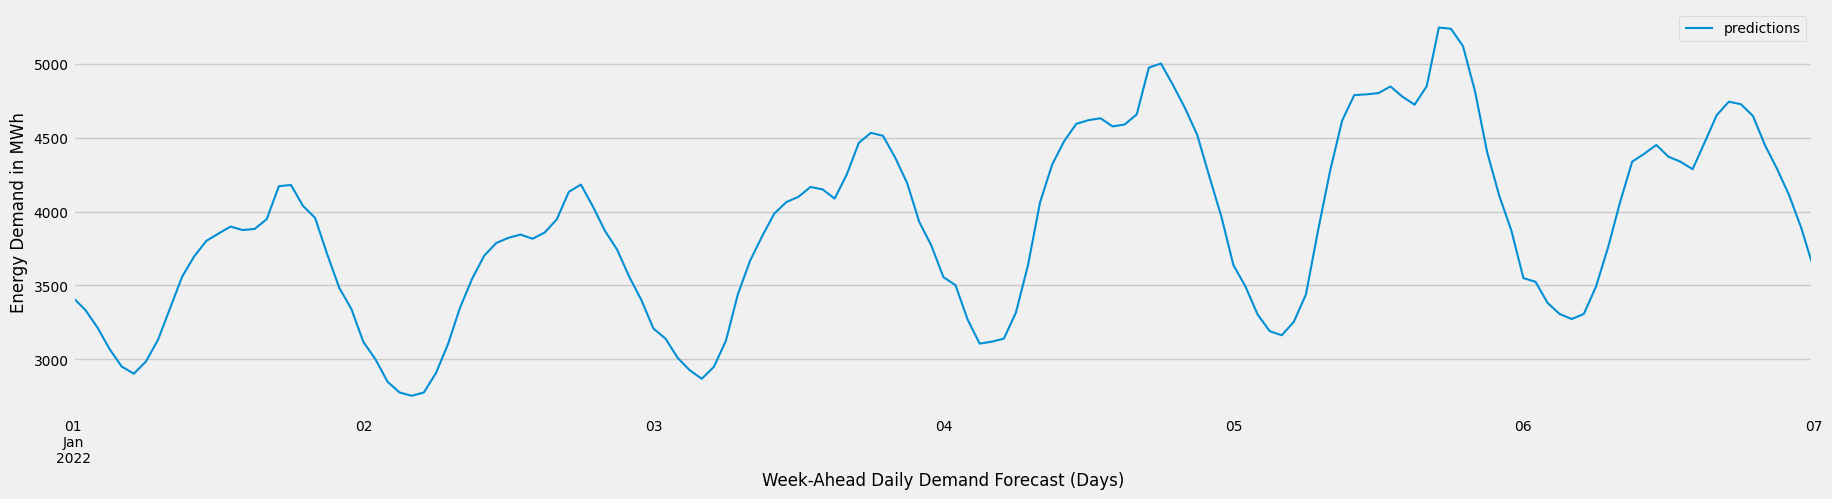

In [189]:
fig, ax = plt.subplots(figsize=(20, 5))

#pred_data['IE Demand'].plot(ax=ax, label='test')

result3['yhat'].plot(ax=ax, label='predictions')
plt.xlabel('Week-Ahead Daily Demand Forecast (Days)')
plt.ylabel('Energy Demand in MWh')
ax.legend();
plt.show()

In [238]:
Demand_result['Prophet'] = result3['yhat']
Demand_result.head(2)

Sarimax      Prophet
2022-01-01 00:00:00  3885.592683  3414.890441
2022-01-01 01:00:00  3843.949674  3333.086591

## Model 3: Histogram Gradient Boosting

In [175]:
forecaster = ForecasterAutoreg(
                regressor = HistGradientBoostingRegressor(learning_rate=0.2),
                lags      = [1, 2, 3, 25,50],
                transformer_y    = StandardScaler(),
                transformer_exog = StandardScaler()
             )

forecaster.fit(y=train_df['IE Demand'], exog=train_df.loc[:, train_df.columns != 'IE Demand'])
forecaster

ForecasterAutoreg 
Regressor: HistGradientBoostingRegressor(learning_rate=0.2) 
Lags: [ 1  2  3 25 50] 
Transformer for y: StandardScaler() 
Transformer for exog: StandardScaler() 
Window size: 50 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['IE Generation', 'IE Wind Generation', 'SNSP', 'Hydro Run-of-River', 'Fossil hard coal', 'Fossil oil', 'Fossil peat', 'Fossil gas', 'temp', 'rhum', 'day', 'month', 'hour', 'dayofweek'] 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2021-05-26 18:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'categorical_features': None, 'early_stopping': 'auto', 'l2_regularization': 0.0, 'learning_rate': 0.2, 'loss': 'squared_error', 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'quantile': N

In [176]:
steps = len(test_df)
predictions = forecaster.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'IE Demand'])

In [177]:
y_pred=predictions

In [178]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 156.9524501904466
MSE: 24634.071620784616
MAE: 125.27767513914061
MAPE: 0.03632369993815735
Max Error: 848.8170546107308
Explained Variance Score: 0.9548337899869267
R2Score: 0.9360468267140347


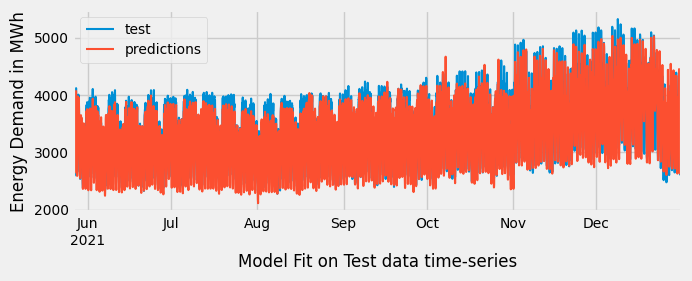

In [180]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
plt.xlabel('Model Fit on Test data time-series')
plt.ylabel('Energy Demand in MWh')
ax.legend();

In [181]:
last_window = test_df['IE Demand'].tail(50)

In [184]:
pred_data=pred_data.drop(pred_data[pred_data.index<=pd.to_datetime('31-12-2021  23:00:00')].index)
pred_data.shape

(145, 15)

In [185]:
y_pred_hgb = forecaster.predict(steps=145, exog=pred_data.loc[:, pred_data.columns != 'IE Demand'],last_window= last_window)

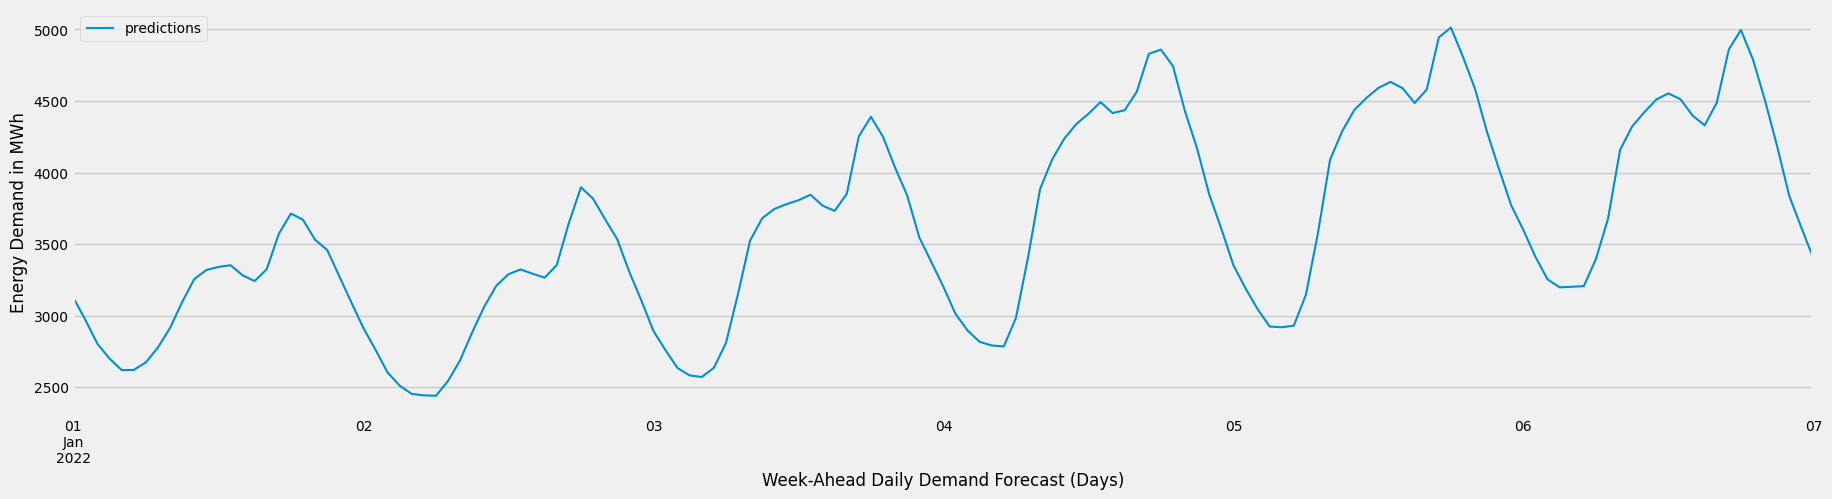

In [191]:
fig, ax = plt.subplots(figsize=(20, 5))


y_pred_hgb.plot(ax=ax, label='predictions')
plt.xlabel('Week-Ahead Daily Demand Forecast (Days)')
plt.ylabel('Energy Demand in MWh')
ax.legend();
plt.show()

In [239]:
Demand_result['HGB'] = y_pred_hgb
Demand_result.head(2)

Sarimax      Prophet          HGB
2022-01-01 00:00:00  3885.592683  3414.890441  3125.108313
2022-01-01 01:00:00  3843.949674  3333.086591  2968.190455

## Model 4: Random Forest Regressor

In [202]:
forecaster2 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123,n_estimators=100),
                lags      = 10
             )

forecaster2.fit(y=train_df['IE Demand'], exog=train_df.loc[:, train_df.columns != 'IE Demand'])
forecaster2

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['IE Generation', 'IE Wind Generation', 'SNSP', 'Hydro Run-of-River', 'Fossil hard coal', 'Fossil oil', 'Fossil peat', 'Fossil gas', 'temp', 'rhum', 'day', 'month', 'hour', 'dayofweek'] 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2021-05-26 18:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_sc

In [203]:
predictions2 = forecaster2.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'IE Demand'])

In [204]:
y_pred=predictions2

In [205]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 220.99376022528347
MSE: 48838.242058510084
MAE: 187.07479344231132
MAPE: 0.053741652363633347
Max Error: 849.1294999999982
Explained Variance Score: 0.9331136299979204
R2Score: 0.87320973140654


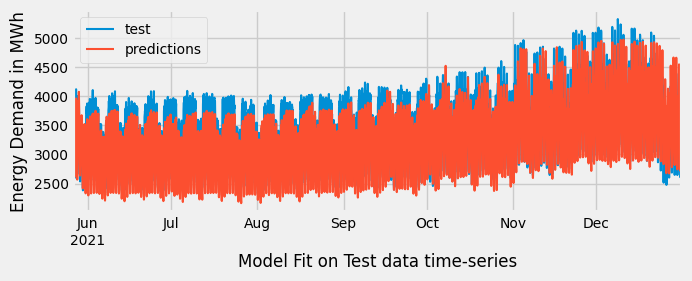

In [206]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
plt.xlabel('Model Fit on Test data time-series')
plt.ylabel('Energy Demand in MWh')
ax.legend();

In [207]:
last_window = test_df['IE Demand'].tail(50)

In [208]:
y_pred_rfr = forecaster2.predict(steps=145, exog=pred_data.loc[:, pred_data.columns != 'IE Demand'],last_window= last_window)

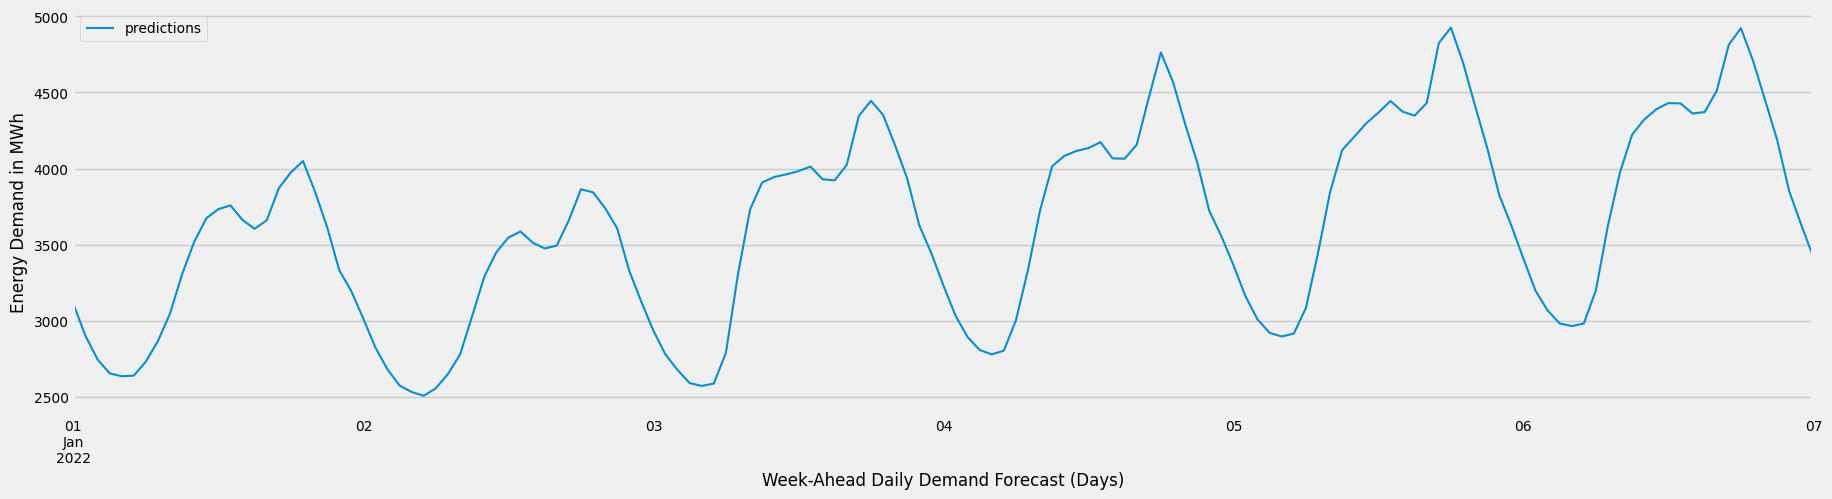

In [209]:
fig, ax = plt.subplots(figsize=(20, 5))
y_pred_rfr.plot(ax=ax, label='predictions')
plt.xlabel('Week-Ahead Daily Demand Forecast (Days)')
plt.ylabel('Energy Demand in MWh')
ax.legend();
plt.show()

In [240]:
Demand_result['RFR'] = y_pred_rfr
Demand_result.head(2)

Sarimax      Prophet          HGB        RFR
2022-01-01 00:00:00  3885.592683  3414.890441  3125.108313  3109.7826
2022-01-01 01:00:00  3843.949674  3333.086591  2968.190455  2900.0685

## Model 5: XGBoosting Regressor

In [212]:
forecaster3 = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state = 123,learning_rate=0.1, n_estimators= 250),
                 lags      = [1, 2, 3, 25,50],
                 transformer_y    = StandardScaler(),
                 transformer_exog = StandardScaler()
             )

forecaster3.fit(y=train_df['IE Demand'], exog=train_df.loc[:, train_df.columns != 'IE Demand'])
forecaster3

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...) 
Lags: [ 1  2  3 25 50] 
Transformer for y: StandardScaler() 
Transformer for exog: StandardScaler() 
Window size: 50 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame

In [213]:
predictions3 = forecaster3.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'IE Demand'])

In [214]:
y_pred=predictions3

In [215]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 154.76049081803703
MSE: 23950.809518239726
MAE: 123.46770143644385
MAPE: 0.03604439001789992
Max Error: 857.9524918207535
Explained Variance Score: 0.9532408994525586
R2Score: 0.9378206617631671


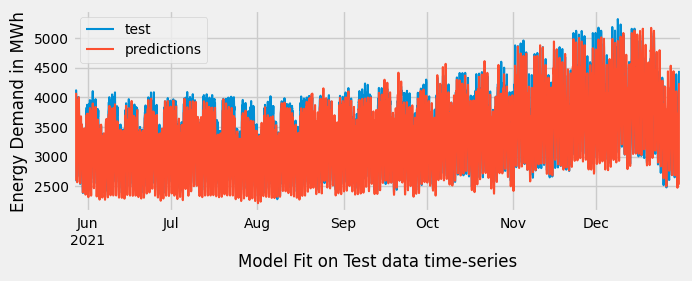

In [216]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
plt.xlabel('Model Fit on Test data time-series')
plt.ylabel('Energy Demand in MWh')
ax.legend();

In [218]:
last_window = test_df['IE Demand'].tail(50)

In [219]:
y_pred_xgb = forecaster3.predict(steps=145, exog=pred_data.loc[:, pred_data.columns != 'IE Demand'],last_window= last_window)

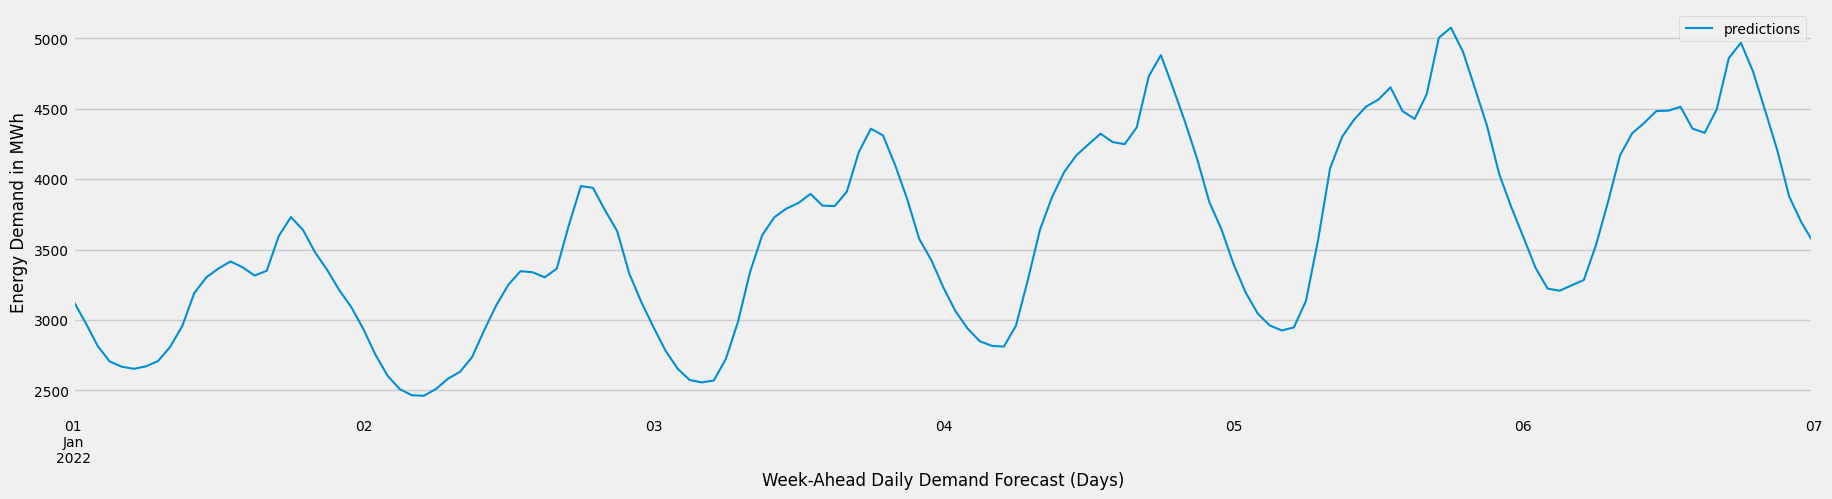

In [220]:
fig, ax = plt.subplots(figsize=(20, 5))
y_pred_xgb.plot(ax=ax, label='predictions')
plt.xlabel('Week-Ahead Daily Demand Forecast (Days)')
plt.ylabel('Energy Demand in MWh')
ax.legend();
plt.show()

In [241]:
Demand_result['XGB'] = y_pred_xgb
Demand_result.head(2)

Sarimax      Prophet          HGB        RFR  \
2022-01-01 00:00:00  3885.592683  3414.890441  3125.108313  3109.7826   
2022-01-01 01:00:00  3843.949674  3333.086591  2968.190455  2900.0685   

                             XGB  
2022-01-01 00:00:00  3134.596906  
2022-01-01 01:00:00  2980.939875

## Model 6: Combined Ensembled Model

In [223]:
r1 = HistGradientBoostingRegressor(random_state=123,learning_rate=0.2)
r2 = RandomForestRegressor(n_estimators=100,random_state=123)
r3 = XGBRegressor(random_state=123,learning_rate=0.1, n_estimators= 250)

In [225]:
forecaster4 = ForecasterAutoreg(
                 regressor = VotingRegressor([('hg', r1), ('rf', r2), ('xg', r3)]),
                 lags      = [1,2,3,25,50],
                 transformer_y    = StandardScaler(),
                 transformer_exog = StandardScaler()
             )

forecaster4.fit(y=train_df['IE Demand'], exog=train_df.loc[:, train_df.columns != 'IE Demand'])
forecaster4

ForecasterAutoreg 
Regressor: VotingRegressor(estimators=[('hg',
                             HistGradientBoostingRegressor(learning_rate=0.2,
                                                           random_state=123)),
                            ('rf', RandomForestRegressor(random_state=123)),
                            ('xg',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, fea...
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
       

In [226]:
predictions4 = forecaster4.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'IE Demand'])

In [227]:
y_pred=predictions4

In [228]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 159.46428985689676
MSE: 25428.859739564385
MAE: 130.79590987416339
MAPE: 0.038033105846773274
Max Error: 616.724211926105
Explained Variance Score: 0.9577425142512213
R2Score: 0.9339834559863527


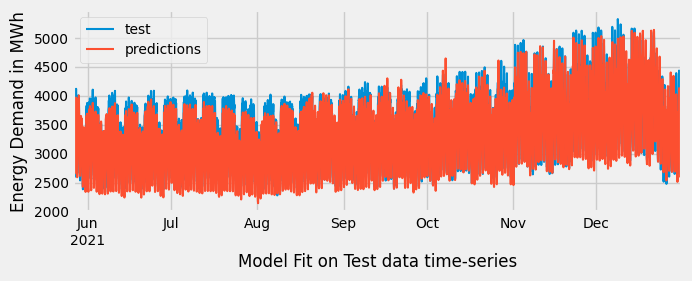

In [229]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
plt.xlabel('Model Fit on Test data time-series')
plt.ylabel('Energy Demand in MWh')
ax.legend();

In [230]:
y_pred_CE = forecaster4.predict(steps=145, exog=pred_data.loc[:, pred_data.columns != 'IE Demand'],last_window= last_window)

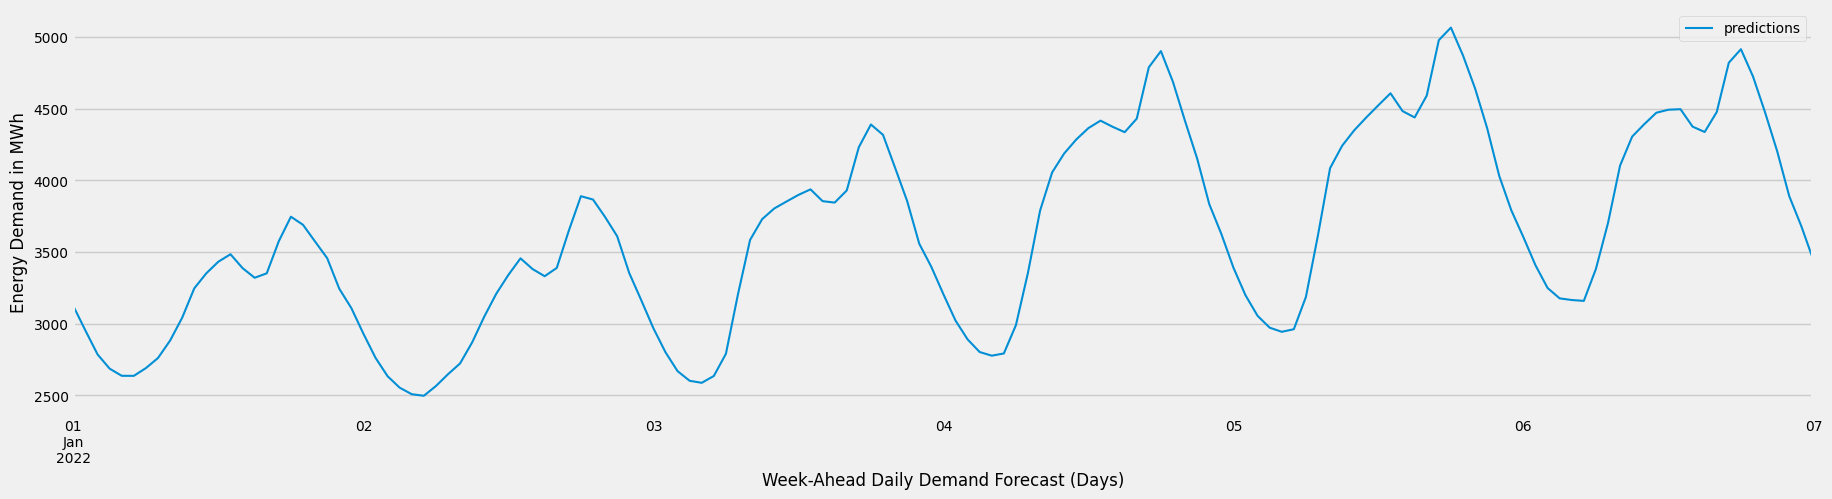

In [231]:
fig, ax = plt.subplots(figsize=(20, 5))
y_pred_CE.plot(ax=ax, label='predictions')
plt.xlabel('Week-Ahead Daily Demand Forecast (Days)')
plt.ylabel('Energy Demand in MWh')
ax.legend();
plt.show()

In [242]:
Demand_result['CEM'] = y_pred_CE
Demand_result.head(2)

Sarimax      Prophet          HGB        RFR  \
2022-01-01 00:00:00  3885.592683  3414.890441  3125.108313  3109.7826   
2022-01-01 01:00:00  3843.949674  3333.086591  2968.190455  2900.0685   

                             XGB          CEM  
2022-01-01 00:00:00  3134.596906  3122.309294  
2022-01-01 01:00:00  2980.939875  2951.509505

In [243]:
Demand_result.to_csv("DemandModelResults.csv")

Comparison of Energy demand models

In [244]:
newdf = Demand_result.copy()

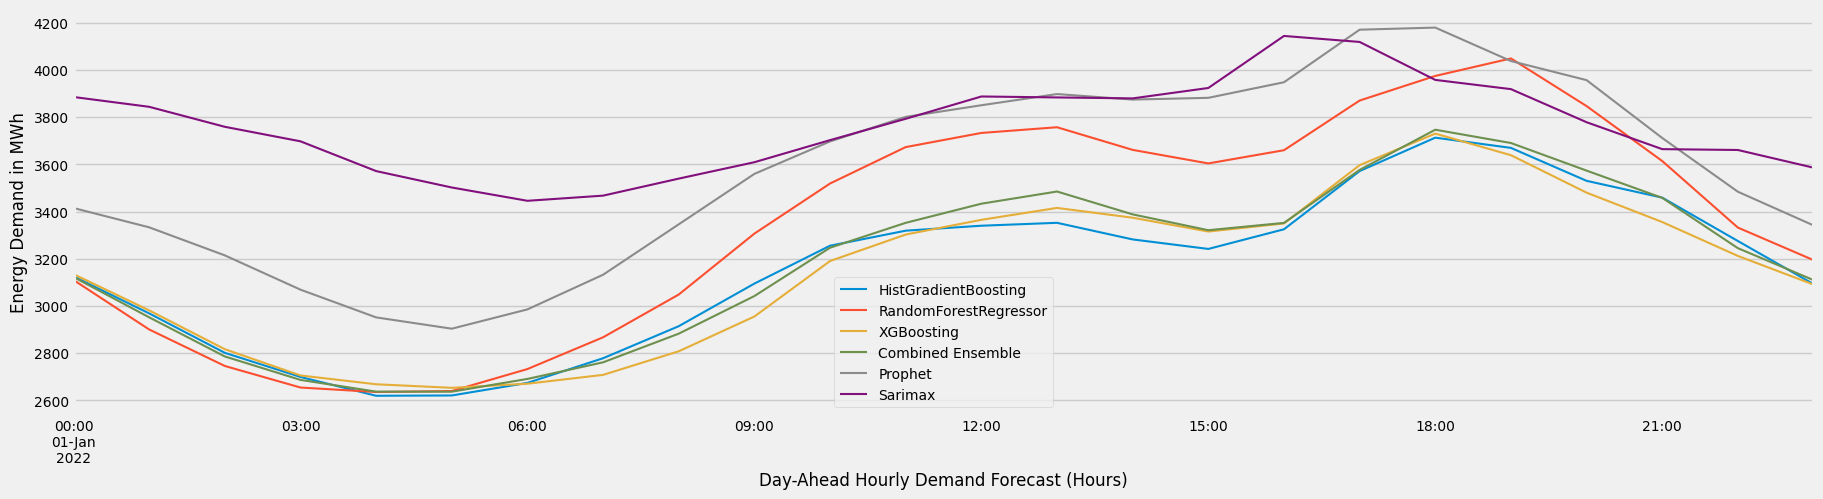

In [249]:
fig, ax = plt.subplots(figsize=(20, 5))
#y_true.head(24).plot(ax=ax, label='Actual')
newdf['HGB'].head(24).plot(ax=ax, label='HistGradientBoosting')
newdf['RFR'].head(24).plot(ax=ax, label='RandomForestRegressor')
newdf['XGB'].head(24).plot(ax=ax, label='XGBoosting')
newdf['CEM'].head(24).plot(ax=ax, label='Combined Ensemble')
newdf['Prophet'].head(24).plot(ax=ax, label='Prophet')
newdf['Sarimax'].head(24).plot(ax=ax, label='Sarimax')
#newypred.head(24).plot(ax=ax, label='combined')
ax.legend();
plt.xlabel('Day-Ahead Hourly Demand Forecast (Hours)')
plt.ylabel('Energy Demand in MWh')
#plt.title('Number of Carriers Flying from Specific Airports')
plt.show()

In [252]:
plottest=test_df.drop(test_df[test_df.index<pd.to_datetime('29-12-2021  23:00:00')].index)

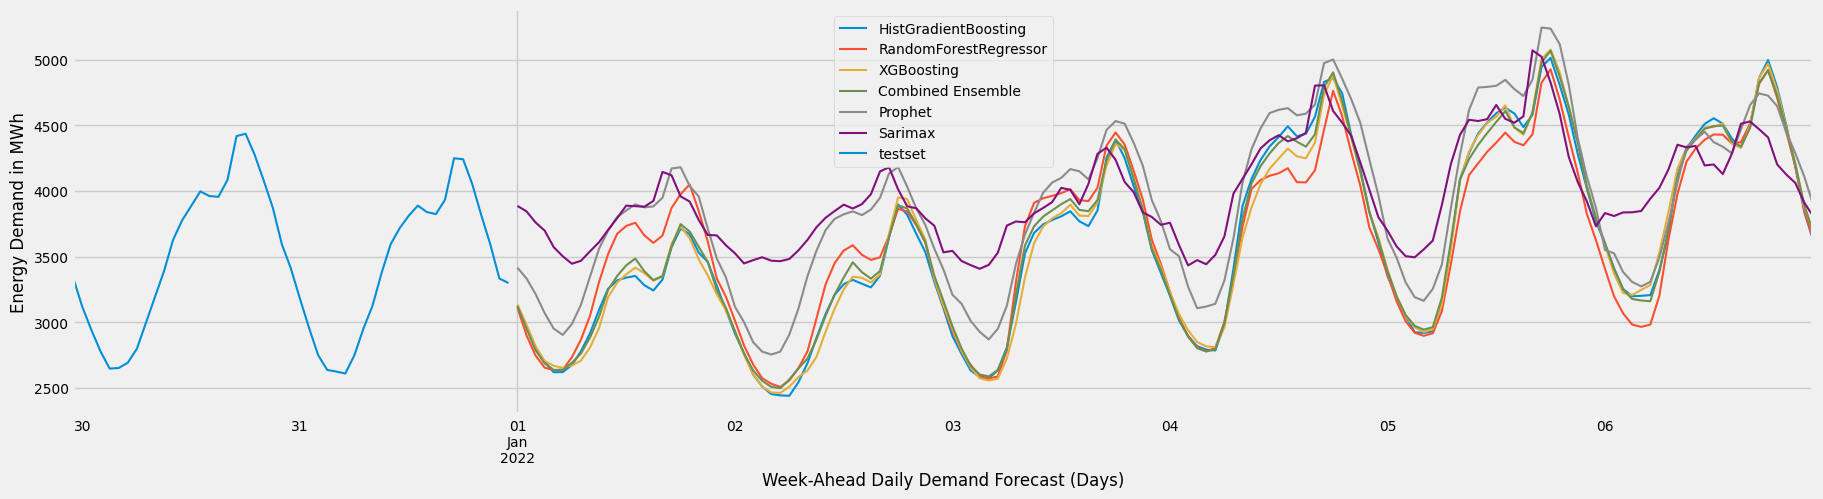

In [253]:
fig, ax = plt.subplots(figsize=(20, 5))
newdf['HGB'].plot(ax=ax, label='HistGradientBoosting')
newdf['RFR'].plot(ax=ax, label='RandomForestRegressor')
newdf['XGB'].plot(ax=ax, label='XGBoosting')
newdf['CEM'].plot(ax=ax, label='Combined Ensemble')
newdf['Prophet'].plot(ax=ax, label='Prophet')
newdf['Sarimax'].plot(ax=ax, label='Sarimax')
plottest['IE Demand'].plot(ax=ax, label='testset')
#y_true.plot(ax=ax, label='Actual')
plt.xlabel('Week-Ahead Daily Demand Forecast (Days)')
plt.ylabel('Energy Demand in MWh')
ax.legend();
plt.show()

# Modelling for Electricity Price Forecast

In [81]:
train_df = data[data.index <= train_cutoff]
test_df = data[data.index > train_cutoff]

print("Train:", train_df.index.min(), train_df.index.max(), len(train_df))
print("Test:", test_df.index.min(), test_df.index.max(), len(test_df))

Train: 2019-01-01 00:00:00 2021-05-26 18:00:00 21043
Test: 2021-05-26 19:00:00 2021-12-31 23:00:00 5261


In [79]:
exogenous_features = list(data)
exogenous_features.remove('ElectricityPrice')
exogenous_features

['IE Generation',
 'IE Demand',
 'IE Wind Generation',
 'SNSP',
 'Hydro Run-of-River',
 'Fossil hard coal',
 'Fossil oil',
 'Fossil peat',
 'Fossil gas',
 'temp',
 'rhum',
 'day',
 'month',
 'hour',
 'dayofweek']

## Model 1: Sarimax

In [82]:
mod = sm.tsa.statespace.SARIMAX(
                train_df['ElectricityPrice'],
                exog=train_df.loc[:, exogenous_features],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = mod.fit()

c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


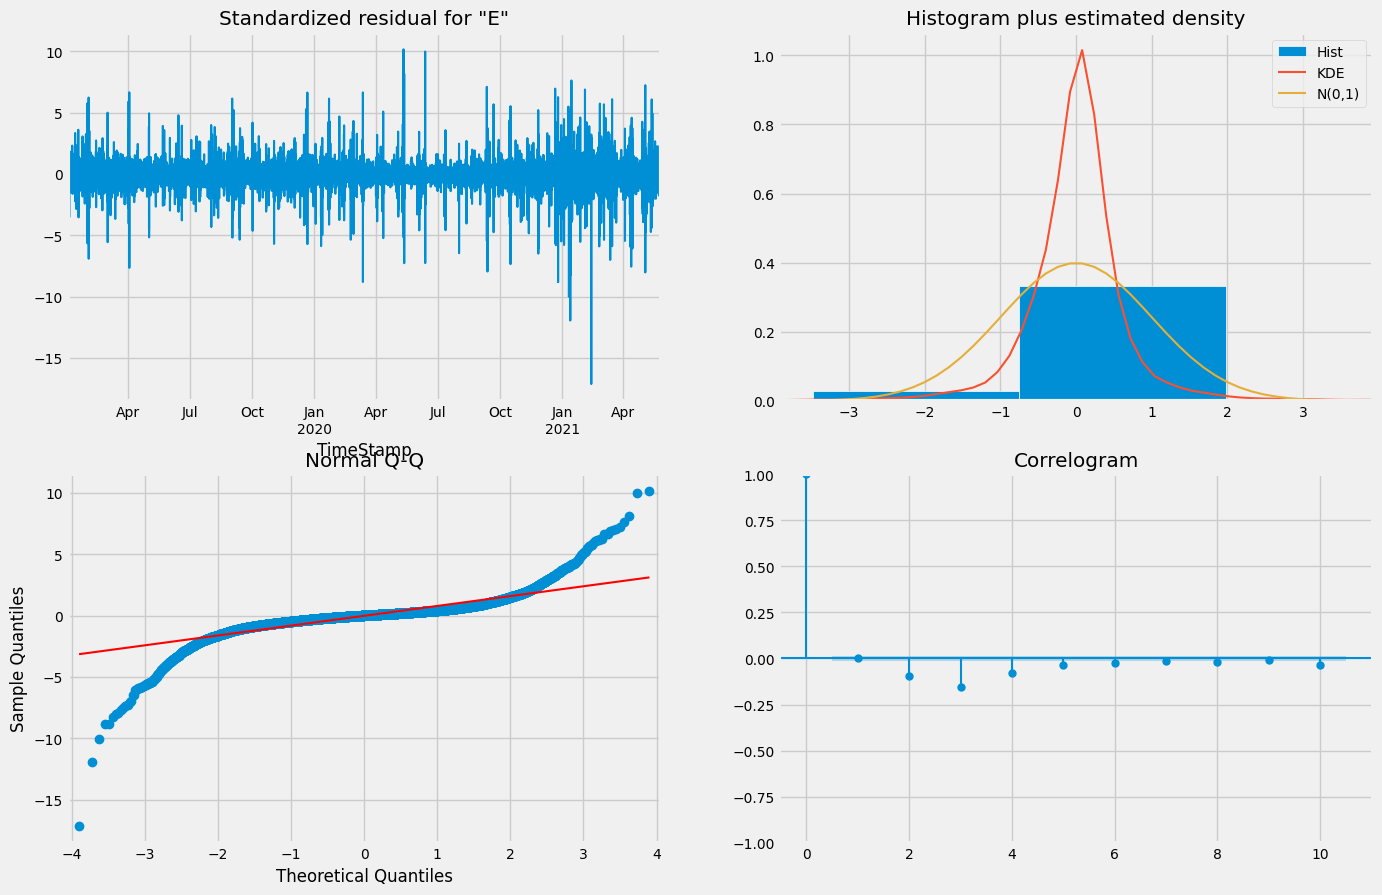

In [83]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

In [84]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                  ElectricityPrice   No. Observations:                21043
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -81723.814
Date:                           Wed, 02 Aug 2023   AIC                         163487.627
Time:                                   11:52:36   BIC                         163646.698
Sample:                               01-01-2019   HQIC                        163539.544
                                    - 05-26-2021                                         
Covariance Type:                             opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
IE Generation         -0.0002      0.002     -0.152      0.880      -0.003       0.003
IE Demand              0.0205      0.001     16.178      0.000       0.018       0.023
IE Wind Generation     0.0008      0.002      0.407      0.684      -0.003       0.004
SNSP                 -13.6779      7.083     -1.931      0.053     -27.561       0.205
Hydro Run-of-River     0.0494      0.010      4.776      0.000       0.029       0.070
Fossil hard coal       0.0557      0.004     12.973      0.000       0.047       0.064
Fossil oil             0.0014      0.002      0.619      0.536      -0.003       0.006
Fossil peat           -0.0080      0.007     -1.086      0.277      -0.022       0.006
Fossil gas             0.0039      0.001      2.598      0.009       0.001       0.007
temp                  -0.2004      0.172     -1.166      0.243      -0.537       0.136
rhum                  -0.0420      0.033     -1.256      0.209      -0.108       0.024
day                   -0.6247      0.059    -10.622      0.000      -0.740      -0.509
month                  1.2021      0.791      1.520      0.128      -0.348       2.752
hour                  -0.5142      0.016    -32.107      0.000      -0.546      -0.483
dayofweek              0.0548      0.129      0.423      0.672      -0.199       0.308
ar.L1                 -0.1529      0.031     -4.961      0.000      -0.213      -0.092
ma.L1                  0.3283      0.031     10.670      0.000       0.268       0.389
ar.S.L7               -0.0633      0.008     -7.798      0.000      -0.079      -0.047
ma.S.L7               -0.9988      0.001  -1037.204      0.000      -1.001      -0.997
sigma2               198.5228      0.889    223.351      0.000     196.781     200.265
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            961823.73
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
steps = len(test_df)
pred = results.get_forecast(steps=steps, exog=test_df.loc[:, exogenous_features])

In [86]:
y_test=test_df['ElectricityPrice']
y_pred=pred.predicted_mean

In [87]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 59.80112806760831
MSE: 3576.17491815849
MAE: 48.85599507845006
MAPE: 702241323680022.5
Max Error: 167.56004878503515
Explained Variance Score: 0.2054554824838526
R2Score: 0.1367482292473996


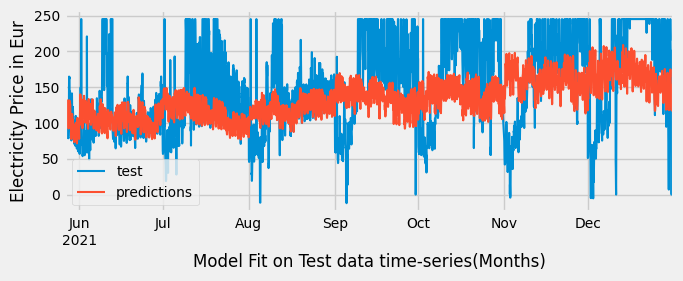

In [89]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
plt.xlabel('Model Fit on Test data time-series(Months)')
plt.ylabel('Electricity Price in Eur')
ax.legend();

In [90]:
pred_data=df.copy()
pred_data['TimeStamp'] = pd.to_datetime(pred_data['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')

In [91]:
pred_data=pred_data.drop(pred_data[pred_data['TimeStamp']>pd.to_datetime('01-07-2022  00:00:00')].index)
pred_data.shape

(26446, 17)

In [92]:
pred_data=pred_data.drop(pred_data[pred_data['TimeStamp']<=pd.to_datetime('26-05-2021  19:00:00')].index)
pred_data.shape

(5405, 17)

In [96]:
pred_data = pred_data.set_index('TimeStamp')
pred_data = pred_data.asfreq('H')
pred_data = pred_data.sort_index()

In [97]:
exog=pred_data.loc[:, pred_data.columns != 'ElectricityPrice']

In [105]:
y_pred= results.forecast(steps=5405, exog=exog)

In [107]:
ypred_sarimax=y_pred.drop(y_pred[y_pred.index<=pd.to_datetime('31-12-2021  23:00:00')].index)

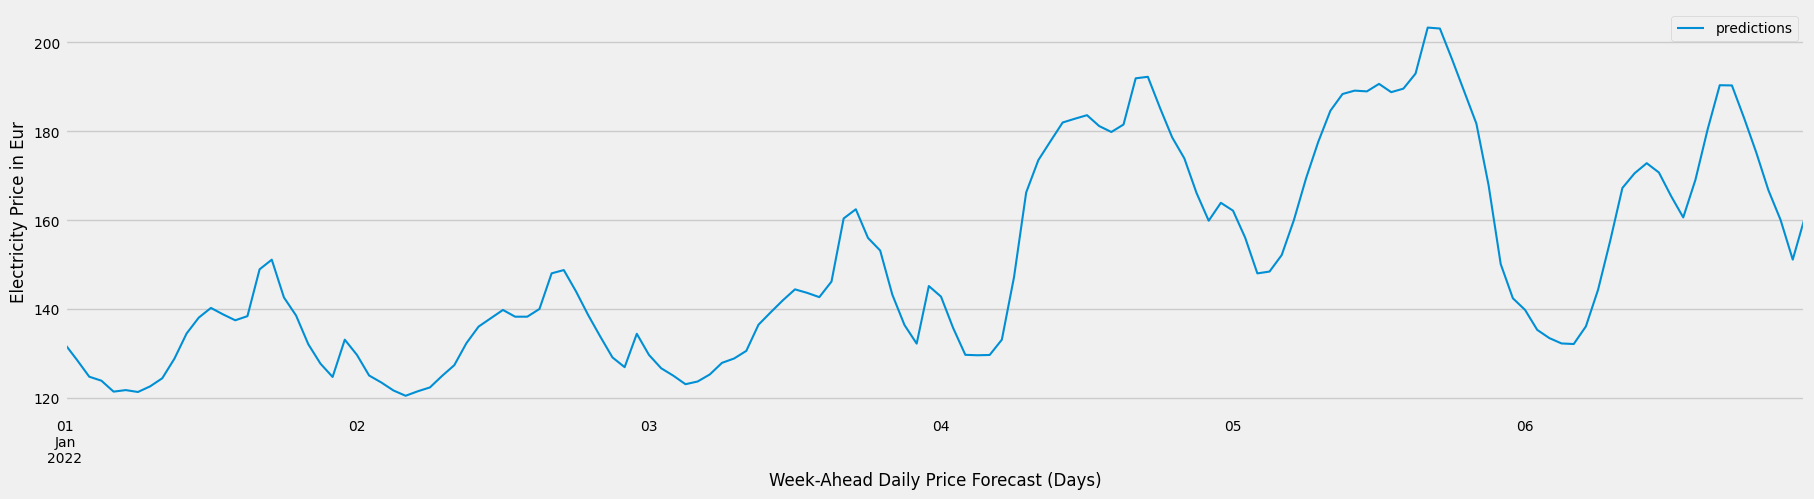

In [114]:
fig, ax = plt.subplots(figsize=(20, 5))

ypred_sarimax.plot(ax=ax, label='predictions')
plt.xlabel('Week-Ahead Daily Price Forecast (Days)')
plt.ylabel('Electricity Price in Eur')
ax.legend();
plt.show()

In [109]:
Price_result = pd.DataFrame(ypred_sarimax)

Price_result=Price_result.rename(columns={'predicted_mean': 'Sarimax'})

Price_result.head(2)

Sarimax
2022-01-01 00:00:00  132.108076
2022-01-01 01:00:00  128.524955

## Model 2: Prophet

In [136]:
model2 = Prophet(changepoint_prior_scale = 0.01, seasonality_prior_scale= 1.0)

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path


In [134]:
exogenous_features = list(data)
exogenous_features.remove('ElectricityPrice')
exogenous_features.remove('SNSP')
exogenous_features.remove('temp')
exogenous_features.remove('day')
exogenous_features.remove('rhum')
exogenous_features.remove('Hydro Run-of-River')
exogenous_features.remove('IE Generation')
exogenous_features.remove('Fossil peat')
exogenous_features.remove('IE Wind Generation')
exogenous_features

['IE Demand',
 'Fossil hard coal',
 'Fossil oil',
 'Fossil gas',
 'month',
 'hour',
 'dayofweek']

In [137]:
for feature in exogenous_features:
	model2.add_regressor(feature)

In [117]:
train_df_prophet = train_df.reset_index()
train_df_prophet.head(2)
test_df_prophet = test_df.reset_index()

In [139]:
model2.fit(train_df_prophet[["TimeStamp", "ElectricityPrice"] + exogenous_features].rename(columns={"TimeStamp": "ds", "ElectricityPrice": "y"}))

cmdstanpy  DEBUG input tempfile: C:\Users\kagau\AppData\Local\Temp\tmp4osxl47f\f95gzjug.json
cmdstanpy  DEBUG input tempfile: C:\Users\kagau\AppData\Local\Temp\tmp4osxl47f\c13qd958.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\kagau\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=46776', 'data', 'file=C:\\Users\\kagau\\AppData\\Local\\Temp\\tmp4osxl47f\\f95gzjug.json', 'init=C:\\Users\\kagau\\AppData\\Local\\Temp\\tmp4osxl47f\\c13qd958.json', 'output', 'file=C:\\Users\\kagau\\AppData\\Local\\Temp\\tmp4osxl47f\\prophet_modelmae0o3wh\\prophet_model-20230802121728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:17:28 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain [1] start processing
12:17:33 - cmdstanpy - INFO - Chain [1] done processing
cmdstanpy  INFO  Chain [1] done processing


In [140]:
forecast2 = model2.predict(test_df_prophet[["TimeStamp"] + exogenous_features].rename(columns={"TimeStamp": "ds"}))

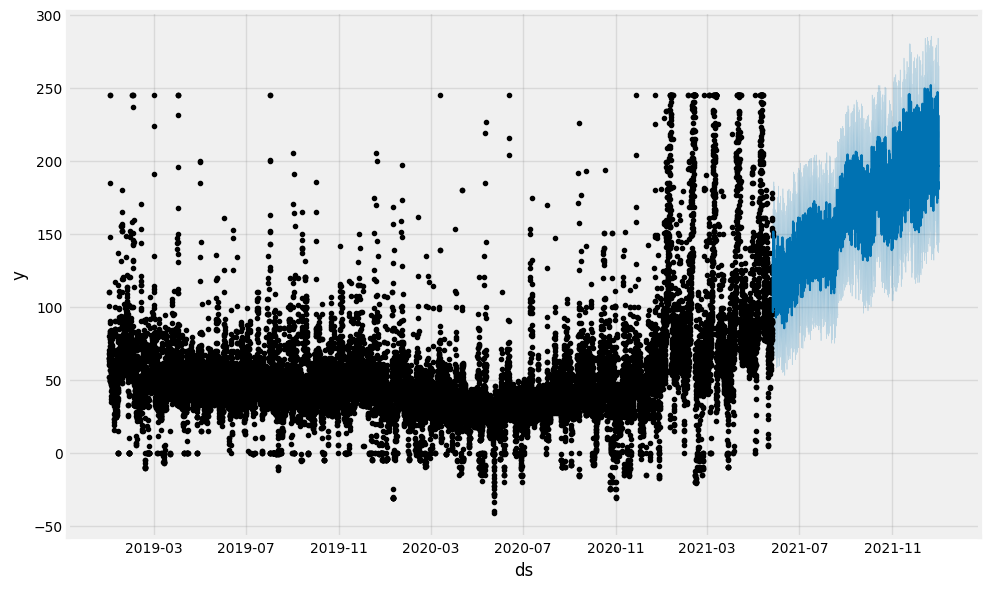

In [141]:
fig3 = model2.plot(forecast2)

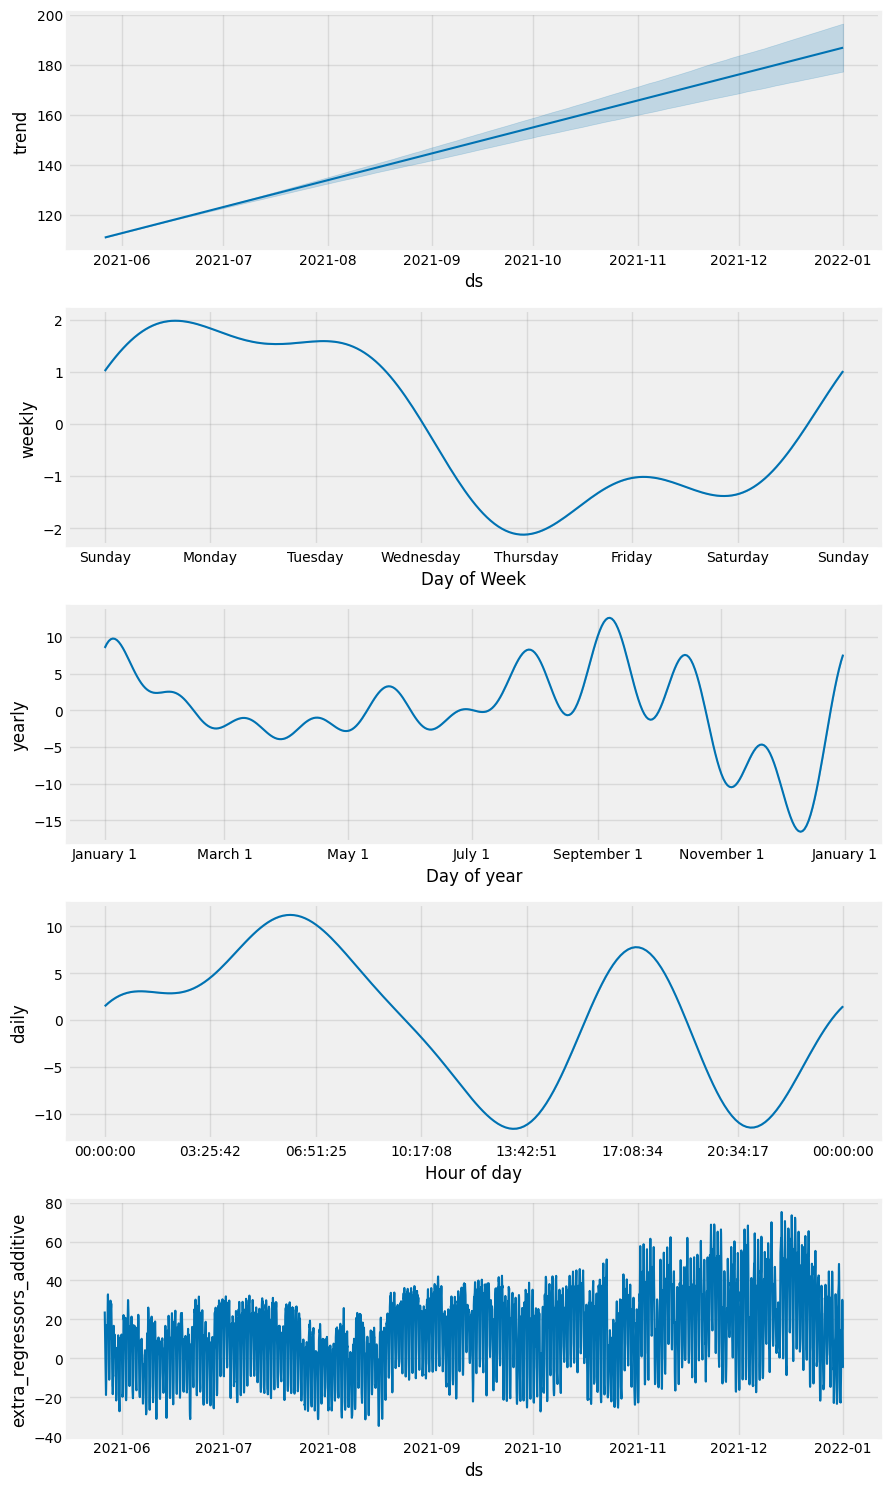

In [142]:
fig4 = model2.plot_components(forecast2)

In [143]:
result2 = forecast2.copy()

In [144]:
result2['TimeStamp'] = pd.to_datetime(result2['ds'], format='%Y-%m-%dT%H:%M:%SZ')
result2 = result2.set_index('TimeStamp')
result2 = result2.asfreq('H')
result2 = result2.sort_index()

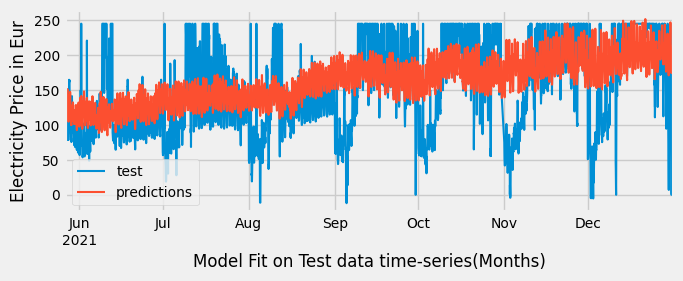

In [145]:
fig, ax = plt.subplots(figsize=(7, 2.5))

test_df['ElectricityPrice'].plot(ax=ax, label='test')

result2['yhat'].plot(ax=ax, label='predictions')
plt.xlabel('Model Fit on Test data time-series(Months)')
plt.ylabel('Electricity Price in Eur')
ax.legend();

In [146]:
y_pred=result2['yhat']

In [147]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 53.64568085086371
MSE: 2877.8590739527253
MAE: 41.57399858549884
MAPE: 942808044057634.6
Max Error: 189.88873892922152
Explained Variance Score: 0.330855116133542
R2Score: 0.3053144775017326


In [149]:
pred_data_prophet = pred_data.reset_index()

In [150]:
pred_data_prophet=pred_data_prophet.drop(pred_data_prophet[pred_data_prophet['TimeStamp']<=pd.to_datetime('31-12-2021  23:00:00')].index)
pred_data_prophet.shape

(145, 17)

In [151]:
pred_data_prophet=pred_data_prophet.drop(pred_data_prophet[pred_data_prophet['TimeStamp']>pd.to_datetime('01-07-2022  00:00:00')].index)
pred_data_prophet.shape

(145, 17)

In [153]:
forecast3 = model2.predict(pred_data_prophet[["TimeStamp"] + exogenous_features].rename(columns={"TimeStamp": "ds"}))

In [154]:
result3 = forecast3.copy()

In [155]:
result3['TimeStamp'] = pd.to_datetime(result3['ds'], format='%Y-%m-%dT%H:%M:%SZ')
result3 = result3.set_index('TimeStamp')
result3 = result3.asfreq('H')
result3 = result3.sort_index()

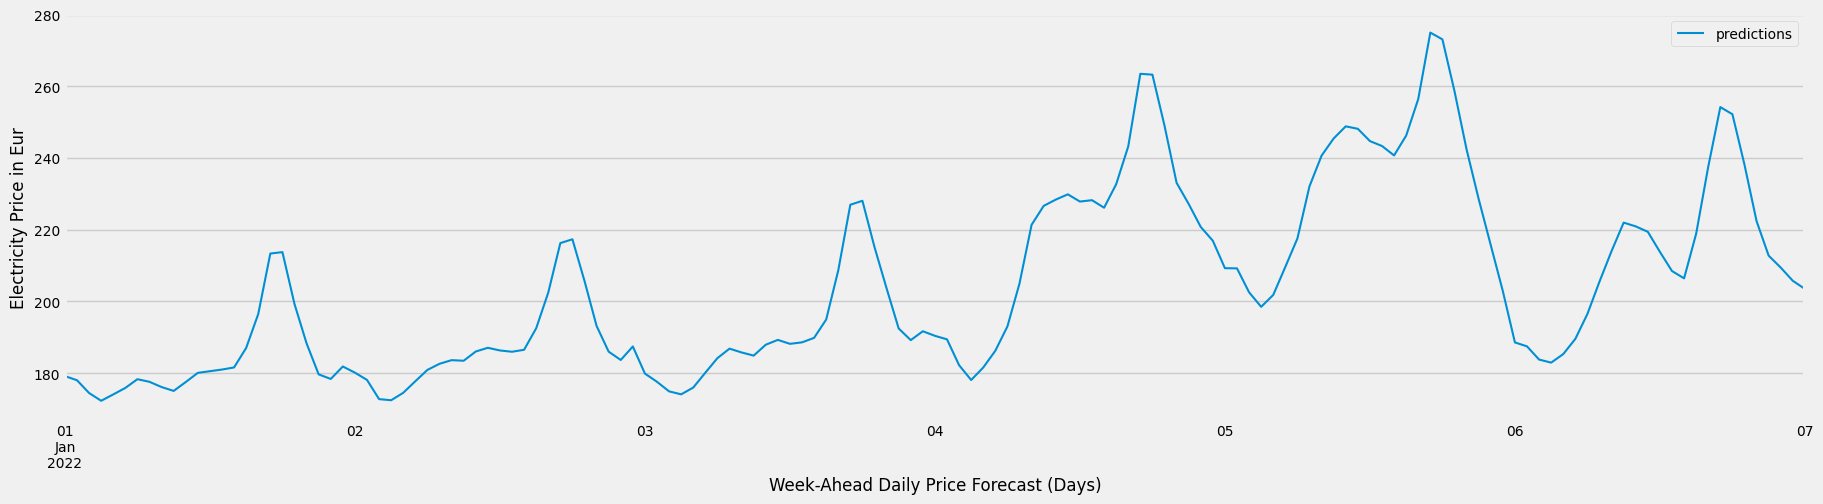

In [157]:
fig, ax = plt.subplots(figsize=(20, 5))

#result3['yhat_lower'].plot(ax=ax, label='lower')
#result3['yhat_upper'].plot(ax=ax, label='upper')
result3['yhat'].plot(ax=ax, label='predictions')
plt.xlabel('Week-Ahead Daily Price Forecast (Days)')
plt.ylabel('Electricity Price in Eur')
ax.legend();
plt.show()

In [158]:
Price_result['Prophet'] = result3['yhat']
Price_result.head(2)

Sarimax     Prophet
2022-01-01 00:00:00  132.108076  179.207591
2022-01-01 01:00:00  128.524955  178.046934

## Model 3: Histogram Gradient Boosting

In [160]:
exogenous_features = list(data)
exogenous_features.remove('ElectricityPrice')
exogenous_features

['IE Generation',
 'IE Demand',
 'IE Wind Generation',
 'SNSP',
 'Hydro Run-of-River',
 'Fossil hard coal',
 'Fossil oil',
 'Fossil peat',
 'Fossil gas',
 'temp',
 'rhum',
 'day',
 'month',
 'hour',
 'dayofweek']

In [169]:
forecaster = ForecasterAutoreg(
                regressor = HistGradientBoostingRegressor(learning_rate=0.1),
                lags      = 300,
                transformer_y    = StandardScaler(),
                transformer_exog = StandardScaler()
             )

forecaster.fit(y=train_df['ElectricityPrice'], exog=train_df.loc[:, exogenous_features])
forecaster
#train_df.columns==

ForecasterAutoreg 
Regressor: HistGradientBoostingRegressor() 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 23

In [170]:
steps = len(test_df)
predictions = forecaster.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'ElectricityPrice'])

In [171]:

y_pred=predictions

In [172]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 67.70424500231304
MSE: 4583.864791333231
MAE: 56.93031736622649
MAPE: 745348866792723.4
Max Error: 167.34497699730326
Explained Variance Score: -0.03373787866172395
R2Score: -0.10649772132693602


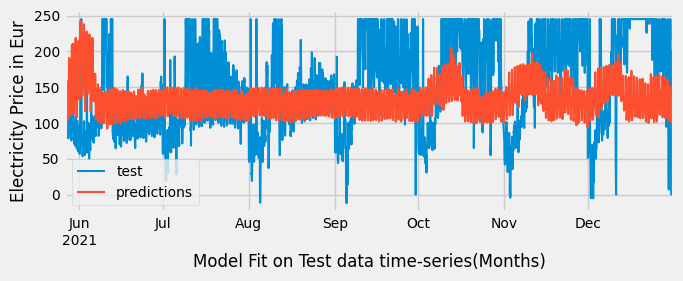

In [173]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
plt.xlabel('Model Fit on Test data time-series(Months)')
plt.ylabel('Electricity Price in Eur')
ax.legend();

In [174]:
last_window = test_df['ElectricityPrice'].tail(300)

In [177]:
pred_data=pred_data.drop(pred_data[pred_data.index<=pd.to_datetime('31-12-2021  23:00:00')].index)
pred_data.shape

(145, 16)

In [178]:
y_pred_hgb = forecaster.predict(steps=145, exog=pred_data.loc[:, pred_data.columns != 'ElectricityPrice'],last_window= last_window)

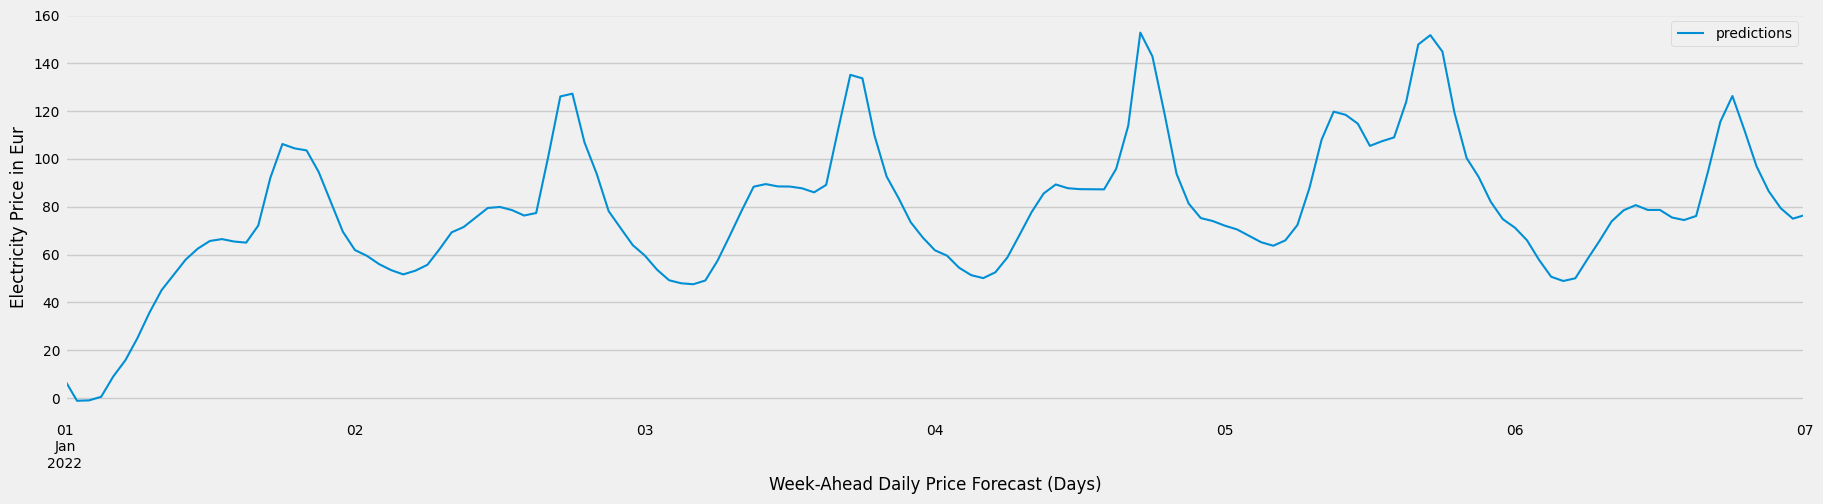

In [181]:
fig, ax = plt.subplots(figsize=(20, 5))



y_pred_hgb.plot(ax=ax, label='predictions')
plt.xlabel('Week-Ahead Daily Price Forecast (Days)')
plt.ylabel('Electricity Price in Eur')
ax.legend();
plt.show()

In [182]:
Price_result['HGB'] = y_pred_hgb
Price_result.head(2)

Sarimax     Prophet       HGB
2022-01-01 00:00:00  132.108076  179.207591  7.456666
2022-01-01 01:00:00  128.524955  178.046934 -1.158031

## Model 4: Random Forest Regressor

In [184]:
forecaster2 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123,n_estimators=100),
                lags      = 50,
                transformer_y    = StandardScaler(),
                transformer_exog = StandardScaler()
             )

forecaster2.fit(y=train_df['ElectricityPrice'], exog=train_df.loc[:, train_df.columns != 'ElectricityPrice'])
forecaster2

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] 
Transformer for y: StandardScaler() 
Transformer for exog: StandardScaler() 
Window size: 50 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['IE Generation', 'IE Demand', 'IE Wind Generation', 'SNSP', 'Hydro Run-of-River', 'Fossil hard coal', 'Fossil oil', 'Fossil peat', 'Fossil gas', 'temp', 'rhum', 'day', 'month', 'hour', 'dayofweek'] 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2021-05-26 18:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': N

In [185]:
predictions2 = forecaster2.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'ElectricityPrice'])

In [186]:
y_pred=predictions2

In [187]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 76.92584985145274
MSE: 5917.586375368251
MAE: 64.35333652347462
MAPE: 1056690854549619.8
Max Error: 221.77585
Explained Variance Score: -0.06315592985297225
R2Score: -0.42844436696306776


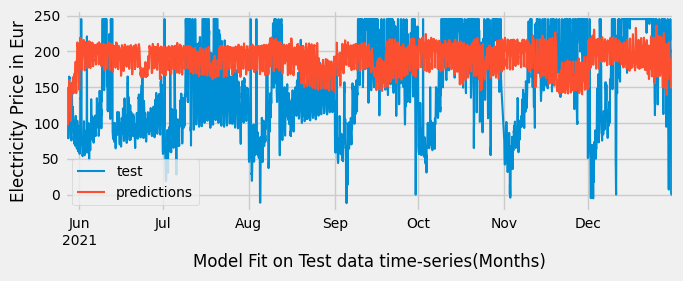

In [188]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
plt.xlabel('Model Fit on Test data time-series(Months)')
plt.ylabel('Electricity Price in Eur')
ax.legend();

In [189]:
last_window = test_df['ElectricityPrice'].tail(50)

In [190]:
y_pred_rfr = forecaster2.predict(steps=145, exog=pred_data.loc[:, pred_data.columns != 'ElectricityPrice'],last_window= last_window)

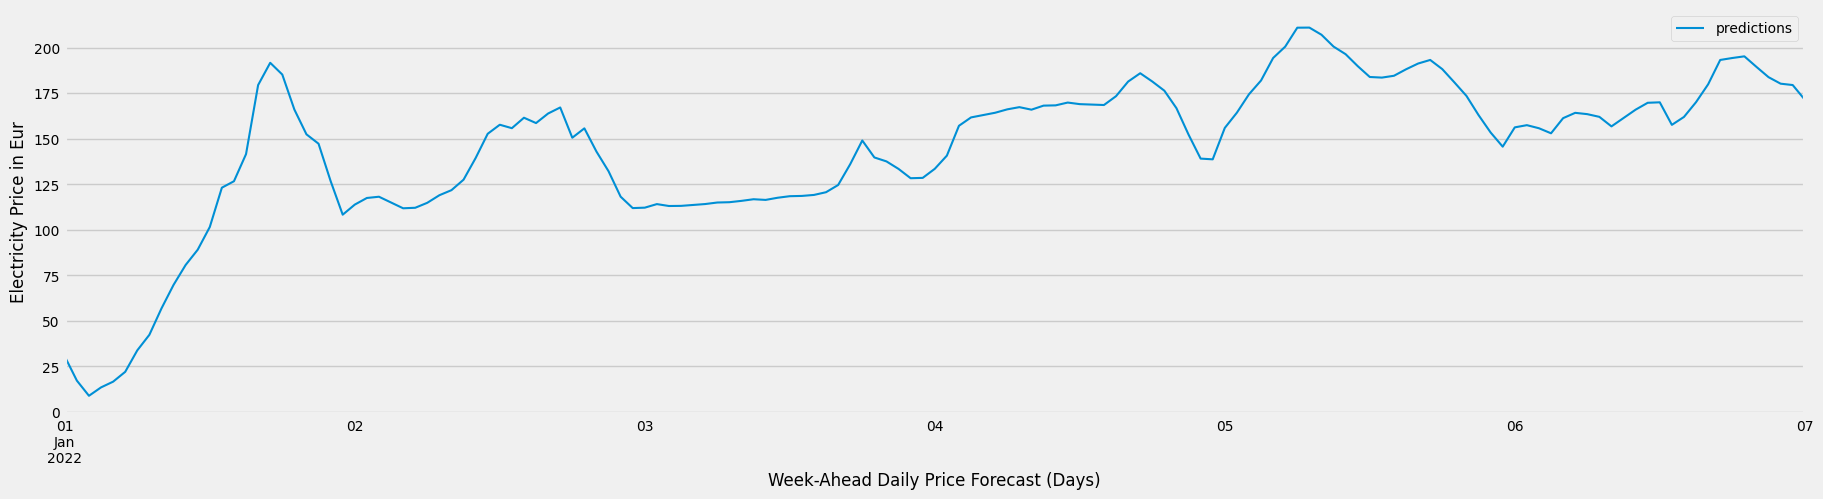

In [191]:
fig, ax = plt.subplots(figsize=(20, 5))


y_pred_rfr.plot(ax=ax, label='predictions')
plt.xlabel('Week-Ahead Daily Price Forecast (Days)')
plt.ylabel('Electricity Price in Eur')
ax.legend();
plt.show()

In [192]:
Price_result['RFR'] = y_pred_rfr
Price_result.head(2)

Sarimax     Prophet       HGB      RFR
2022-01-01 00:00:00  132.108076  179.207591  7.456666  30.4353
2022-01-01 01:00:00  128.524955  178.046934 -1.158031  17.1850

## Model 5: XGBoosting Regressor

In [193]:
forecaster3 = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state = 123,learning_rate=0.1, n_estimators= 100),
                 lags      = 50,
                 transformer_y    = StandardScaler(),
                 transformer_exog = StandardScaler()
             )

forecaster3.fit(y=train_df['ElectricityPrice'], exog=train_df.loc[:, exogenous_features])
forecaster3

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] 
Transformer for y: StandardScaler() 
Transformer for exog: StandardSc

In [194]:
predictions3 = forecaster3.predict(steps=steps, exog=test_df.loc[:, exogenous_features])

In [195]:
y_pred = predictions3

In [196]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 75.93366540495688
MSE: 5765.921541831945
MAE: 63.333989293623134
MAPE: 737147667690258.9
Max Error: 192.7596348139218
Explained Variance Score: -0.39178707118542455
R2Score: -0.3918340391386861


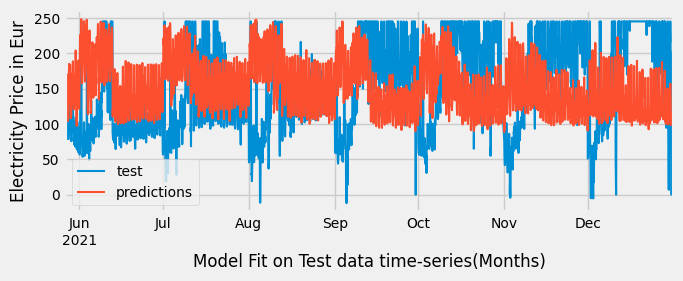

In [197]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
plt.xlabel('Model Fit on Test data time-series(Months)')
plt.ylabel('Electricity Price in Eur')
ax.legend();

In [198]:
last_window = test_df['ElectricityPrice'].tail(50)

In [200]:
y_pred_xgb = forecaster3.predict(steps=145, exog=pred_data.loc[:, pred_data.columns != 'ElectricityPrice'],last_window= last_window)

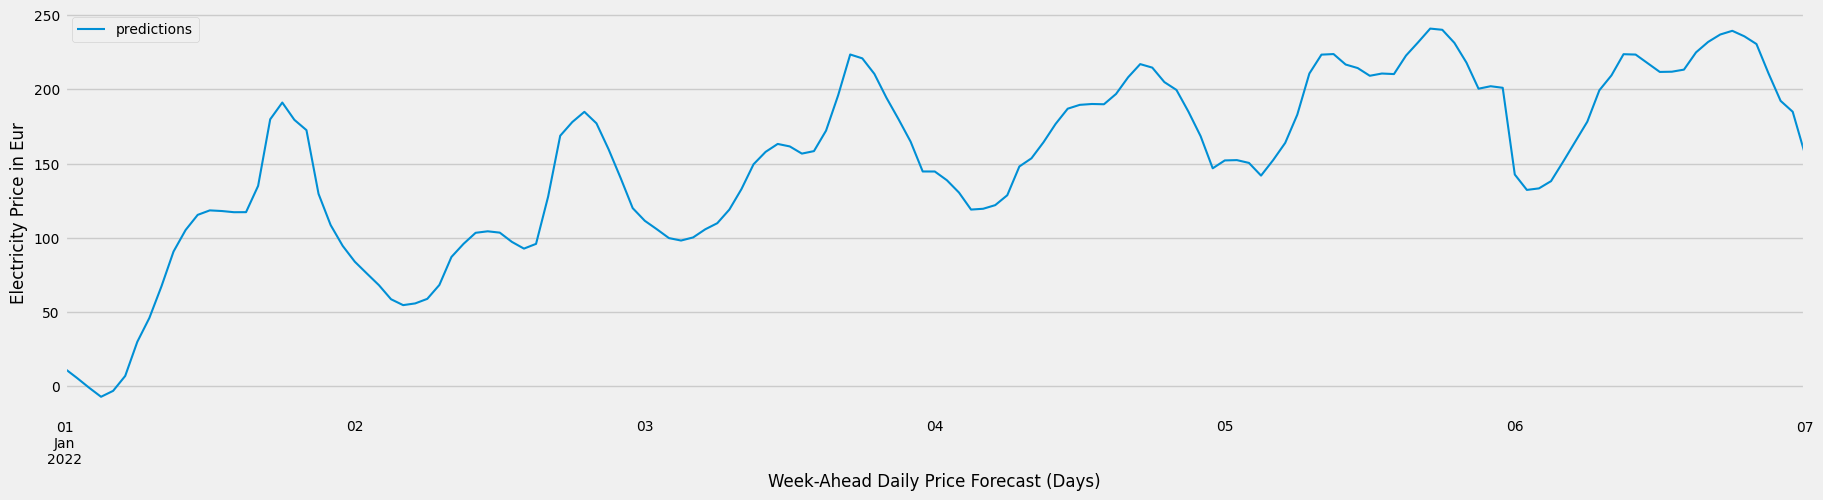

In [201]:
fig, ax = plt.subplots(figsize=(20, 5))


y_pred_xgb.plot(ax=ax, label='predictions')
plt.xlabel('Week-Ahead Daily Price Forecast (Days)')
plt.ylabel('Electricity Price in Eur')
ax.legend();
plt.show()

In [202]:
Price_result['XGB'] = y_pred_xgb
Price_result.head(2)

Sarimax     Prophet       HGB      RFR        XGB
2022-01-01 00:00:00  132.108076  179.207591  7.456666  30.4353  11.973358
2022-01-01 01:00:00  128.524955  178.046934 -1.158031  17.1850   5.758698

## Model 6: Combined Ensembled Model

In [204]:
r1 = HistGradientBoostingRegressor(random_state=123,learning_rate=0.1)
r2 = RandomForestRegressor(n_estimators=100,random_state=123)
r3 = XGBRegressor(random_state=123,learning_rate=0.1, n_estimators= 100,lags_grid=[50])

In [205]:
forecaster4 = ForecasterAutoreg(
                 regressor = VotingRegressor([('hg', r1), ('rf', r2), ('xg', r3)]),
                 lags      = 300,
                 transformer_y    = StandardScaler(),
                 transformer_exog = StandardScaler()
             )

forecaster4.fit(y=train_df['ElectricityPrice'], exog=train_df.loc[:, train_df.columns != 'ElectricityPrice'])
forecaster4

[12:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "lags_grid" } are not used.



ForecasterAutoreg 
Regressor: VotingRegressor(estimators=[('hg',
                             HistGradientBoostingRegressor(random_state=123)),
                            ('rf', RandomForestRegressor(random_state=123)),
                            ('xg',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          ga...=None,
                                          grow_policy=None,
                                          importance_type=None,
                     

In [206]:
predictions4 = forecaster4.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'ElectricityPrice'])

In [207]:
y_pred=predictions4

In [208]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 64.35661759178447
MSE: 4141.774227855183
MAE: 55.31304203886456
MAPE: 860567355850264.4
Max Error: 171.77866693549615
Explained Variance Score: 0.0009134615916537303
R2Score: 0.00021838470513646513


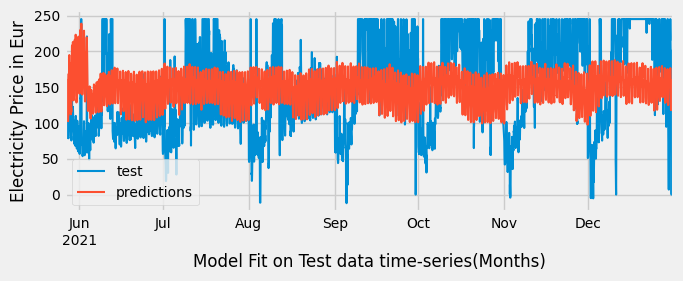

In [222]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
plt.xlabel('Model Fit on Test data time-series(Months)')
plt.ylabel('Electricity Price in Eur')
ax.legend();

In [210]:
last_window = test_df['ElectricityPrice'].tail(300)

In [211]:
y_pred_CE = forecaster4.predict(steps=145, exog=pred_data.loc[:, pred_data.columns != 'ElectricityPrice'],last_window= last_window)

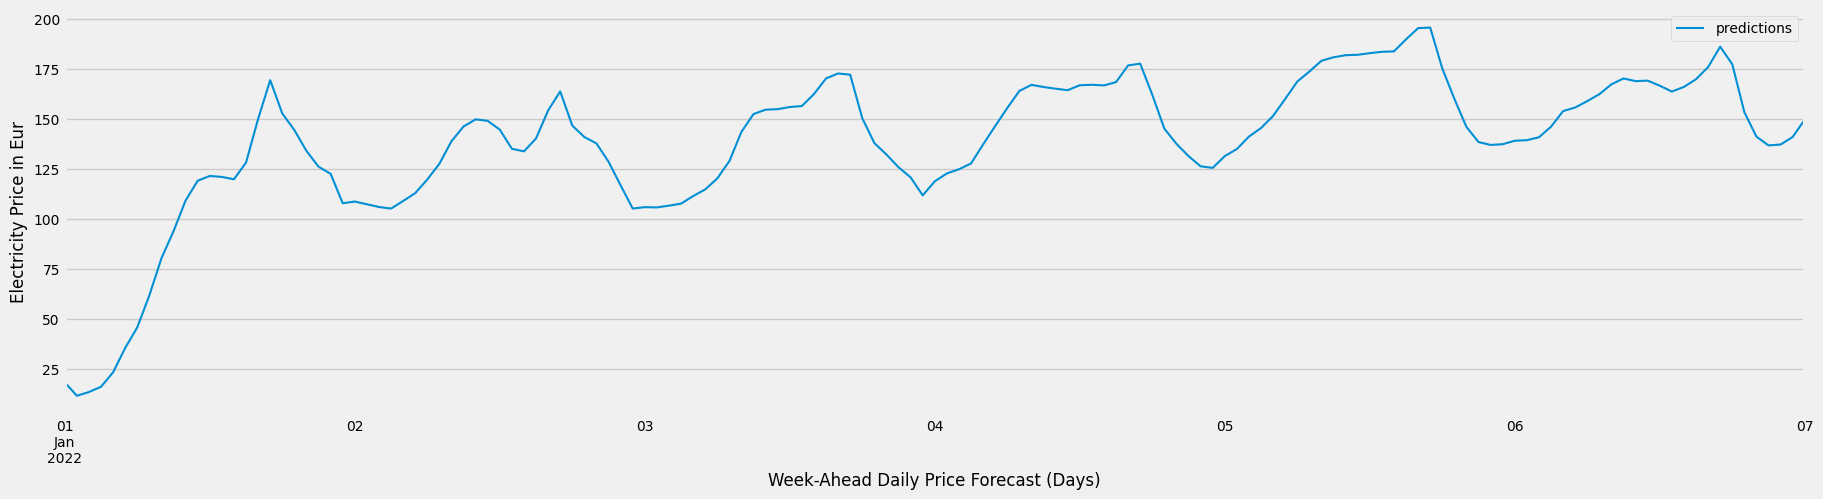

In [212]:
fig, ax = plt.subplots(figsize=(20, 5))
y_pred_CE.plot(ax=ax, label='predictions')
plt.xlabel('Week-Ahead Daily Price Forecast (Days)')
plt.ylabel('Electricity Price in Eur')
ax.legend();
plt.show()

In [213]:
Price_result['CEM'] = y_pred_CE
Price_result.head(2)

Sarimax     Prophet       HGB      RFR        XGB  \
2022-01-01 00:00:00  132.108076  179.207591  7.456666  30.4353  11.973358   
2022-01-01 01:00:00  128.524955  178.046934 -1.158031  17.1850   5.758698   

                           CEM  
2022-01-01 00:00:00  18.238809  
2022-01-01 01:00:00  11.585469

In [214]:
Price_result.to_csv("PriceModelResults.csv")

Comparison of Electricity Price models

In [215]:
newdf = Price_result.copy()

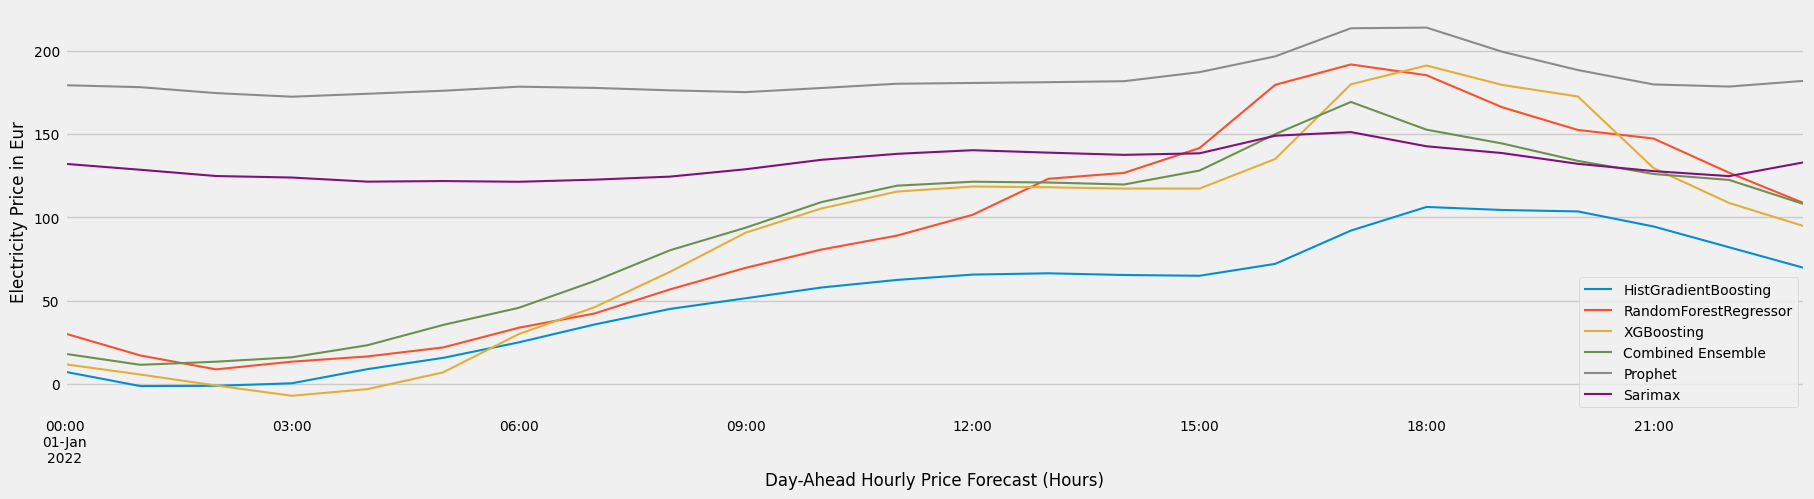

In [223]:
fig, ax = plt.subplots(figsize=(20, 5))
#y_true.head(24).plot(ax=ax, label='Actual')
newdf['HGB'].head(24).plot(ax=ax, label='HistGradientBoosting')
newdf['RFR'].head(24).plot(ax=ax, label='RandomForestRegressor')
newdf['XGB'].head(24).plot(ax=ax, label='XGBoosting')
newdf['CEM'].head(24).plot(ax=ax, label='Combined Ensemble')
newdf['Prophet'].head(24).plot(ax=ax, label='Prophet')
newdf['Sarimax'].head(24).plot(ax=ax, label='Sarimax')
#newypred.head(24).plot(ax=ax, label='combined')
ax.legend();
plt.xlabel('Day-Ahead Hourly Price Forecast (Hours)')
plt.ylabel('Electricity Price in Eur')
#plt.title('Number of Carriers Flying from Specific Airports')
plt.show()

In [218]:
plottest=test_df.drop(test_df[test_df.index<pd.to_datetime('29-12-2021  23:00:00')].index)

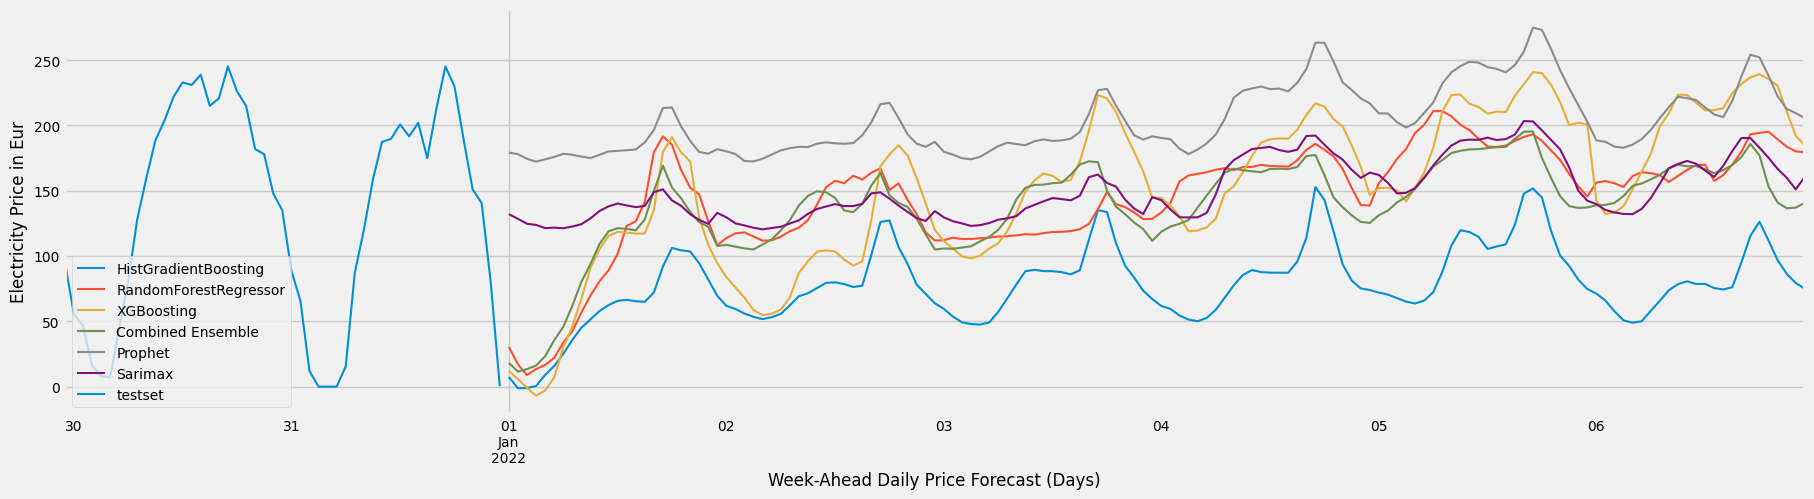

In [224]:
fig, ax = plt.subplots(figsize=(20, 5))
newdf['HGB'].plot(ax=ax, label='HistGradientBoosting')
newdf['RFR'].plot(ax=ax, label='RandomForestRegressor')
newdf['XGB'].plot(ax=ax, label='XGBoosting')
newdf['CEM'].plot(ax=ax, label='Combined Ensemble')
newdf['Prophet'].plot(ax=ax, label='Prophet')
newdf['Sarimax'].plot(ax=ax, label='Sarimax')
plottest['ElectricityPrice'].plot(ax=ax, label='testset')
#y_true.plot(ax=ax, label='Actual')
plt.xlabel('Week-Ahead Daily Price Forecast (Days)')
plt.ylabel('Electricity Price in Eur')
ax.legend();
plt.show()

In [225]:
df = pd.read_excel("..\Datasets\Result_Price.xlsx")

<AxesSubplot: title={'center': 'Evaluation Metrics for Electricity Price'}, xlabel='Error Metric', ylabel='Models Evaluated'>

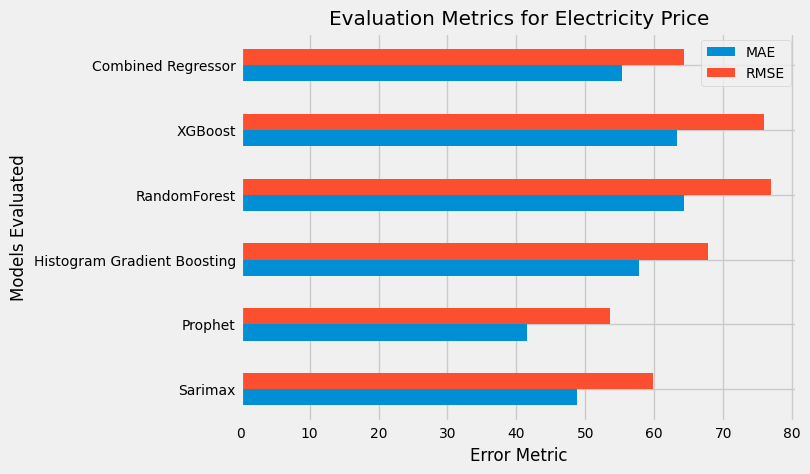

In [226]:
df.plot(x='Model',y=['MAE','RMSE'],
        kind='barh',
        stacked=False,
        title='Evaluation Metrics for Electricity Price',xlabel='Error Metric',ylabel='Models Evaluated')



In [227]:
newdf = pd.read_excel("..\Datasets\Result_Demand.xlsx")

<AxesSubplot: title={'center': 'Evaluation Metrics for Energy Demand'}, xlabel='Error Metric', ylabel='Models Evaluated'>

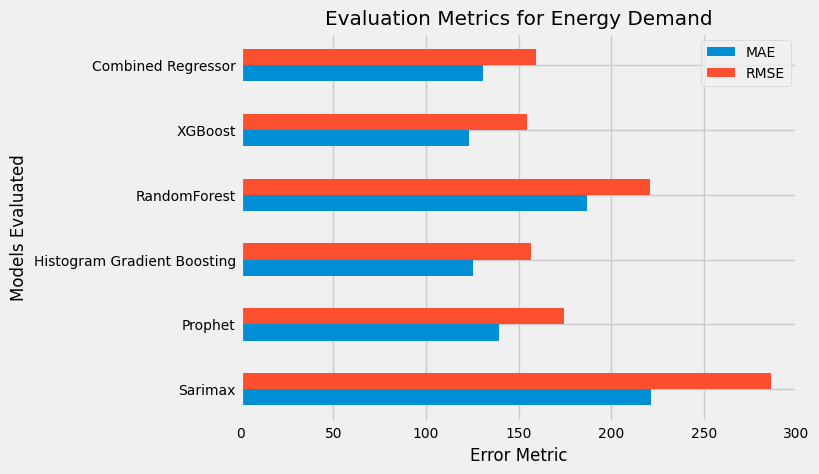

In [228]:
newdf.plot(x='Model',y=['MAE','RMSE'],
        kind='barh',
        stacked=False,
        title='Evaluation Metrics for Energy Demand',xlabel='Error Metric',ylabel='Models Evaluated')